#  Automatically Tagging Topics of News Website

##### June 17th, 2018
## Table of Contents

### [1. Project Overview](#overview)
### [2. Problem Statement](#statement)
### [3. Solution Strategy](#solution)
### [4. Evaluation Metrics](#metrics)
### [5. Data Exploration](#exploration)
### [6. Data Cleaning](#cleaning)
### [7. Data Visualization](#visualization)
### [8. Data Preparation](#preparation)
### [9.Modelling](#model)
### [10. Keyword Generation](#pred)
### [11. Conclusions and Further Improvement](#conclusion)



<a id='overview'></a>
## Project Overview

News articles account for a large percentage of the content found on the internet. They offer recent, relevant and mostly interesting information pertaining current events, specific topics or personal opinions. The content of these vary according to the subject matter at hand. One problem with news articles however, is the difficulty of finding both recent and historical information pertaining a specific topic. To solve this, news are tagged with certain keywords, pertaining the content of the article itself. However, these tags have to be manually input before or after the article has been written. In addition, some articles are missing tags about certain topics that are mentioned in their content, however brief. 

This project focuses on using a dataset of news articles , their content, and their keywords,  to classify keywords articles that are missing their keywords, and for future articles. The data contains the full content of the website, including scripts and other website specific text, as well as multiple keywords assigned to the article. With the content of the article, we can accurately classify and assign keywords to news articles.

<a id='statement'></a>
## Problem Statement

As mentioned in the previous section, the news keywords are central to quickly identifying the topics present in an article. This project is looking to use the raw content of an article to assign one or multiple keywords to an article.  Because of the nature of the data (news article contents), and the objective of the problem (Classifying multiple keywords),  we are faced with a **Multilabel Classification** Problem.


<a id='solution'></a>
## Solution Strategy

Given the nature of the problem at hand, a lot of algorithms are not well optimized for the problem. Not a lot of algorithms come with multilabel classification built-in. There are alternative methods to train multilabel classifiers, such as training one model per label. However, since we are predicting news keywords, which are numerous in unique labels, this approach is not technically feasible. Because of these reasons, three algorithms that have multilabel classification built-in will be evaluated: Random Forest, K-Nearest Neighbors and a Neural Network.

The data cleaning process is key in this project, since the raw data consists of the large strings that are news articles. These articles have some text that is related to the website itself, words that occur commonly in articles, and the actual content of the article. The latter is the one in which we are interested. We'll also use the Term Frequency-Inverse Document Frequency algorithm to convert the cleaned article content into numerical format, for easier consumption for the learning algorithms. Finally, we'll use cross validation and parameter optimization to obtain the best model, and use it to predict news keywords for a large number of articles in the data that are missing keywords.

<a id='metrics'></a>
## Evaluation Metrics

To measure the quality of the multilabel classification algorithm, we'll use a metric that takes both multiple lables into account, and the rarity of some keywords. We'll use the <a href="https://en.wikipedia.org/wiki/F1_score">F1 Score</a> metric. This metric is the harmonic mean of two other metrics **Precision** and **Recall**. 

- Precision is the amount of true positives, positive instances that were classified correctly, divided by the sum of true   positives and false positives, negative instances that were classified as positive. This metric measures how well the model avoids assigning the wrong keyword to an article. 

- Recall is the amount of true positives, positive instances that were classified correctly, divided by the sum of true   positives and false negatives, positive instances that were classified as negative. This metric measures how well the model  assigns  keywords correctly to an article. 


The harmonic mean of these two metrics, results in the F1 Score. This means that it takes both, how well the model avoids the wrong keywords, and how well the model assigns the correct keywords. Since some keywords appear infrequently, we can't use accuracy as a metric, as predicting no keywords most of the time will yield high accuracy. We'll use a weighted version of this metric, which takes into account how often a label appears in the data, and works better overall for evaluating multilabel classification. 

<a id='exploration'></a>
## Data Exploration

The dataset used in this project is a news article dataset. This dataset contains information about the articles content, its title, the date it was made and its keywords.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings
import re #Regular Expressions.
from nltk.corpus import stopwords
english_stopwords = set(stopwords.words('english'))
import keras as Ke
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import collections
from itertools import chain
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers.normalization import BatchNormalization
from keras.metrics import top_k_categorical_accuracy
from numpy.random import seed
import sklearn.metrics as sklm
from sklearn.model_selection import KFold
import gc 
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Doc2Vec
import gensim
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot as ipy
from sklearn.model_selection import train_test_split
import  plotly
plotly.offline.init_notebook_mode(connected=True)
seed(777)
warnings.filterwarnings("ignore")
%matplotlib inline
pd.options.mode.chained_assignment = None
plotly_config={'showLink': False}

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Set plot parameters
rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 12
rcParams["patch.force_edgecolor"] = True
sns.set()

In [3]:
pages = pd.read_csv('aje_ga_pages_with_meta_and_body.csv')
print("The Articles Data has {} rows and {} columns.".format(pages.shape[0],pages.shape[1]))

The Articles Data has 21709 rows and 11 columns.


Let's take a look at the data.

In [4]:
pages.head()

,Unnamed: 0,url,title,path,html_file_name,description,news_keywords,content_type,last_modified_date,article_body,keywords
0,www.aljazeera.com/programmes/ajeats/2016/01/ch...,http://www.aljazeera.com/programmes/ajeats/201...,The chronicler of Indian food,/programmes/ajeats/2016/01/chronicler-indian-f...,html_files/b0403b537aeab0a51da7e52a4b84ec8adc1...,"For 40 years, food historian Pushpesh Pant has...",NaN,Programs,"Wed, 06 January 2016 11:21:29 GMT","Delhi, India - It is a winter afternoon and th...",NaN
1,www.aljazeera.com/news/2017/04/reports-borders...,http://www.aljazeera.com/news/2017/04/reports-...,Reporters Without Borders: Journalism at tippi...,/news/2017/04/reports-borders-journalism-tippi...,html_files/64efe6c26edb72c02672d928ef0b91caa17...,Reporters Without Borders warns of tipping poi...,"Press Freedom, Media",News,"Wed, 26 April 2017 09:46:36 GMT",Media freedom is being undermined by the rise ...,NaN
2,www.aljazeera.com/news/2018/03/israeli-forces-...,http://www.aljazeera.com/news/2018/03/israeli-...,Israeli forces raid village of driver who kill...,/news/2018/03/israeli-forces-raid-village-driv...,html_files/56153dbfe8ea391400478ea1cc3c9bc61af...,Israel suspends work permits of at least 100 m...,"Occupied West Bank, Israeli–Palestinian confl...",News,"Sat, 17 March 2018 09:26:05 GMT",The incident happened as other confrontations ...,NaN
3,www.aljazeera.com/news/2017/11/eastern-ghouta-...,http://www.aljazeera.com/news/2017/11/eastern-...,Eastern Ghouta shelled despite 'truce agreement',/news/2017/11/eastern-ghouta-shelled-truce-agr...,html_files/d72d1ab5c85056866aabe427232776d0870...,UK-based monitoring group says Syrian governme...,"Bashar al-Assad, Syria's Civil War, Middle Eas...",News,"Wed, 29 November 2017 21:03:09 GMT",A wounded man is seen in a hospital in Douma a...,NaN
4,www.aljazeera.com/news/2017/03/middle-aged-pal...,http://www.aljazeera.com/news/2017/03/middle-a...,Middle-aged Palestinian woman shot dead in Jer...,/news/2017/03/middle-aged-palestinian-woman-sh...,html_files/9207a8046309a44623b4931ff23638ad62f...,Israeli officers gun down mother of Palestinia...,"Middle East, Jerusalem, Palestine",News,"Wed, 29 March 2017 18:17:59 GMT",Human rights groups have accused Israeli secur...,NaN


Let's take only the columns that we'll use.

In [5]:
pages=pages[['title','description','article_body','news_keywords','last_modified_date']]
pages.last_modified_date = pd.to_datetime(pages.last_modified_date)
pages.description = pages.description.fillna('')
pages=pages.loc[pd.notnull(pages.article_body)].reset_index(drop=True)
pages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21218 entries, 0 to 21217
Data columns (total 5 columns):
title                 21218 non-null object
description           21218 non-null object
article_body          21218 non-null object
news_keywords         13058 non-null object
last_modified_date    15565 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 828.9+ KB


In [6]:
pages['Week'] = pages.last_modified_date.dt.weekofyear.fillna(-1)
pages['Month'] = pages.last_modified_date.dt.month.fillna(-1)
pages.head(10)

,title,description,article_body,news_keywords,last_modified_date,Week,Month
0,The chronicler of Indian food,"For 40 years, food historian Pushpesh Pant has...","Delhi, India - It is a winter afternoon and th...",NaN,2016-01-06 11:21:29,1.0,1.0
1,Reporters Without Borders: Journalism at tippi...,Reporters Without Borders warns of tipping poi...,Media freedom is being undermined by the rise ...,"Press Freedom, Media",2017-04-26 09:46:36,17.0,4.0
2,Israeli forces raid village of driver who kill...,Israel suspends work permits of at least 100 m...,The incident happened as other confrontations ...,"Occupied West Bank, Israeli–Palestinian confl...",2018-03-17 09:26:05,11.0,3.0
3,Eastern Ghouta shelled despite 'truce agreement',UK-based monitoring group says Syrian governme...,A wounded man is seen in a hospital in Douma a...,"Bashar al-Assad, Syria's Civil War, Middle Eas...",2017-11-29 21:03:09,48.0,11.0
4,Middle-aged Palestinian woman shot dead in Jer...,Israeli officers gun down mother of Palestinia...,Human rights groups have accused Israeli secur...,"Middle East, Jerusalem, Palestine",2017-03-29 18:17:59,13.0,3.0
5,Netanyahu in India: What was swept under the c...,,OPINION / Narendra Modi Netanyahu in India...,NaN,NaT,-1.0,-1.0
6,London Muslims Eid comes one week after attack,A van attack on worshippers in Finsbury Park -...,"RenderPagesVideo(5482757389001, 0, 100%, 473, ...",NaN,2017-06-25 19:40:04,25.0,6.0
7,Brazil congress to vote on whether to remove p...,Brazil's President Michel Temer denies allegat...,If two-thirds of legislators in Brazils Lower ...,"Latin America, Brazil",2017-08-02 01:20:21,31.0,8.0
8,I listen to refugees and I hear my own story,The thoughts of a former European refugee on h...,more on RefugeesEstimated 60 percent o...,"Refugees, Greece, Human Rights, Europe",2017-04-12 07:59:17,15.0,4.0
9,Iran's Rouhani urges Turkey to halt Afrin oper...,Iranian president says Turkey's operation agai...,"Iran, Turkey and Russia are involved in peace ...","Turkey-Syria border, Iran, Turkey, Middle East...",2018-02-06 19:10:44,6.0,2.0


And a peek at one example article.

In [7]:
pages.article_body.loc[3]

'A wounded man is seen in a hospital in Douma after an air raid [File: Bassam Khabieh/Reuters]        more on Bashar al-AssadEstimated 60 percent of Yarmouk destroyed amid violence: Group3 days agoStaffan de Mistura calls for de-escalation in Syrialast weekAssad forces target ISIL in southern Damascuslast weekTrump still considering new sanctions against Russialast weekSyrian government forces have shelled a rebel-held enclave near the capital Damascus, according to a monitor, despite the announcement of a truce\xa0a day earlier.The UK-based Syrian Observatory for Human Rights (SOHR)\xa0said the towns of Douma and Irbin in Eastern Ghouta were targeted on Wednesday with artillery shells. At least one person was killed in Irbin as a result of the shelling.Misraba and Ein Tarma, two other towns in the district, were also struck, but only material damage was reported.The reported shelling came after Staffan de Mistura, UN envoy to Syria, announced on Tuesday that the Syrian government had 

As it can be observed, the articles contain some information that is not useful for the classification task, like javascript functions, file routes, and source tags. This will only create noise in the data, so we must first clean the data before creating a model. 

<a id='cleaning'></a>
## Data Cleaning

The first thing to clean is the SOURCE: tag present in a large quantity of articles.

In [8]:
pages.article_body = pages.article_body.str.split('SOURCE:').apply(lambda x:x[0])
pages.article_body.loc[3]

'A wounded man is seen in a hospital in Douma after an air raid [File: Bassam Khabieh/Reuters]        more on Bashar al-AssadEstimated 60 percent of Yarmouk destroyed amid violence: Group3 days agoStaffan de Mistura calls for de-escalation in Syrialast weekAssad forces target ISIL in southern Damascuslast weekTrump still considering new sanctions against Russialast weekSyrian government forces have shelled a rebel-held enclave near the capital Damascus, according to a monitor, despite the announcement of a truce\xa0a day earlier.The UK-based Syrian Observatory for Human Rights (SOHR)\xa0said the towns of Douma and Irbin in Eastern Ghouta were targeted on Wednesday with artillery shells. At least one person was killed in Irbin as a result of the shelling.Misraba and Ein Tarma, two other towns in the district, were also struck, but only material damage was reported.The reported shelling came after Staffan de Mistura, UN envoy to Syria, announced on Tuesday that the Syrian government had 

Next, let's remove the initial tags that plague a large number of articles.

In [9]:
pages.article_body

0        Delhi, India - It is a winter afternoon and th...
1        Media freedom is being undermined by the rise ...
2        The incident happened as other confrontations ...
3        A wounded man is seen in a hospital in Douma a...
4        Human rights groups have accused Israeli secur...
5         OPINION  /  Narendra Modi  Netanyahu in India...
6        RenderPagesVideo(5482757389001, 0, 100%, 473, ...
7        If two-thirds of legislators in Brazils Lower ...
8                more on RefugeesEstimated 60 percent o...
9        Iran, Turkey and Russia are involved in peace ...
10        NEWS  /  Politics  Whats behind Hungarys camp...
11        NEWS  /  Venezuela  Venezuelas Capriles says ...
12       RenderPagesVideo(5683173351001, 0, 100%, 473, ...
13       Willie Corey Godbolt is arrested near Brookhav...
14        NEWS  /  Turkey  Turkey forces encircle Kurdi...
15       UN Syria envoy De Mistura, left, held talks wi...
16       RenderPagesVideo(5387091864001, 0, 100%, 473, .

In [10]:
pages.article_body = pages.article_body.str.split('  /'
                                                 ).apply(lambda x:'  /'.join(x[1:]) if len(x) >1 else x[0])
pages.article_body.head(10)

0    Delhi, India - It is a winter afternoon and th...
1    Media freedom is being undermined by the rise ...
2    The incident happened as other confrontations ...
3    A wounded man is seen in a hospital in Douma a...
4    Human rights groups have accused Israeli secur...
5      Narendra Modi  Netanyahu in India: What was ...
6    RenderPagesVideo(5482757389001, 0, 100%, 473, ...
7    If two-thirds of legislators in Brazils Lower ...
8            more on RefugeesEstimated 60 percent o...
9    Iran, Turkey and Russia are involved in peace ...
Name: article_body, dtype: object

Next, we'll replace several patters that occur frequently with empty text.

In [11]:
replace_list = [';// ]]]] &gt;',';        more on ','Render.+Video\(.+\)']

In [12]:
def replace_with_empty(article_bodies,replace_list):
    for r in replace_list:
        article_bodies = article_bodies.str.replace(r,'')
    return article_bodies

In [13]:
pages.article_body = replace_with_empty(pages.article_body,replace_list)

After, we'll remove all javascript objects and functions, by eliminating all text between brackets.

In [14]:
pages.article_body.loc[14]

'  Turkey  Turkey forces encircle Kurdish-controlled centre of AfrinTurkish army says forces encircle city of Afrin and control areas of critical importance in northern Syria.13 Mar 2018 Turkeys army and allied Syrian rebel forces have surrounded the city of Afrin in northwestern Syria, the main target of Turkeys operation there.\xa0{"requests":{"csi":"https://csi.gstatic.com/csi?"},"transport":{"xhrpost":false},"triggers":{"adRequestStart":{"on":"ad-request-start","request":"csi","sampleSpec":{"sampleOn":"a4a-csi-${pageViewId}","threshold":1},"selector":"amp-ad","selectionMethod":"closest","extraUrlParams":{"met.a4a":"afs_lvt.${viewerLastVisibleTime}~afs.${time}"}},"adResponseEnd":{"on":"ad-response-end","request":"csi","sampleSpec":{"sampleOn":"a4a-csi-${pageViewId}","threshold":1},"selector":"amp-ad","selectionMethod":"closest","extraUrlParams":{"met.a4a":"afe.${time}"}},"adRenderStart":{"on":"ad-render-start","request":"csi","sampleSpec":{"sampleOn":"a4a-csi-${pageViewId}","thresho

In [15]:
def remove_text_inside_brackets(text, brackets="{}"):
    count = [0] * (len(brackets) // 2) # count open/close brackets
    saved_chars = []
    for character in text:
        for i, b in enumerate(brackets):
            if character == b: # found bracket
                kind, is_close = divmod(i, 2)
                count[kind] += (-1)**is_close # `+1`: open, `-1`: close
                if count[kind] < 0: # unbalanced bracket
                    count[kind] = 0  # keep it
                else:  # found bracket to remove
                    break
        else: # character is not a [balanced] bracket
            if not any(count): # outside brackets
                saved_chars.append(character)
    return ''.join(saved_chars)

In [16]:
pages.article_body = pages.article_body.apply(remove_text_inside_brackets)
pages.article_body.loc[14]

'  Turkey  Turkey forces encircle Kurdish-controlled centre of AfrinTurkish army says forces encircle city of Afrin and control areas of critical importance in northern Syria.13 Mar 2018 Turkeys army and allied Syrian rebel forces have surrounded the city of Afrin in northwestern Syria, the main target of Turkeys operation there.\xa0The military said on Tuesday that forces encircled Afrin and also gained the control "areas of critical importance" in the region as of Monday.The Syrian Observatory of Human Rights (SOHR), a UK-based monitoring group, confirmed the development in a separate statement.Turkey - together with the Syrian opposition Free Syrian Army (FSA) rebel group - launched in January an air-and-ground operation into Afrin in the northwest of Syria to vanquish the US-backed Kurdish Peoples Protection Units (YPG) fighters near its border.Turkey considers the Kurdish Democratic Union Party (PYD) in Syria and its armed wing YPG to be "terrorist groups" with ties to the banned 

Finally, we'll do several text cleaning tasks like: 

- Removing extra white space characters
- Removing non-alphabetic characters,
- Removing stopwords, or words that have no actual meaning in the text like and, the, or, etc. 

In [17]:
def Clean_Text(text):
    
    #Remove all non letters.
    remove_space = text.replace("\n"," ")
    letters_only = re.sub("[^a-zA-Z]"," ", text )
    
    words = letters_only.lower().split()
    
    #Remove stopwords from review.
    removed_stops = [w for w in words if not w  in english_stopwords and len(w)!=1]
    
    return " ".join(removed_stops)

In [18]:
pages['clean_article_body'] = pages.article_body.apply(Clean_Text)
pages.head()

,title,description,article_body,news_keywords,last_modified_date,Week,Month,clean_article_body
0,The chronicler of Indian food,"For 40 years, food historian Pushpesh Pant has...","Delhi, India - It is a winter afternoon and th...",NaN,2016-01-06 11:21:29,1.0,1.0,delhi india winter afternoon food historian dr...
1,Reporters Without Borders: Journalism at tippi...,Reporters Without Borders warns of tipping poi...,Media freedom is being undermined by the rise ...,"Press Freedom, Media",2017-04-26 09:46:36,17.0,4.0,media freedom undermined rise surveillance aut...
2,Israeli forces raid village of driver who kill...,Israel suspends work permits of at least 100 m...,The incident happened as other confrontations ...,"Occupied West Bank, Israeli–Palestinian confl...",2018-03-17 09:26:05,11.0,3.0,incident happened confrontations palestinians ...
3,Eastern Ghouta shelled despite 'truce agreement',UK-based monitoring group says Syrian governme...,A wounded man is seen in a hospital in Douma a...,"Bashar al-Assad, Syria's Civil War, Middle Eas...",2017-11-29 21:03:09,48.0,11.0,wounded man seen hospital douma air raid file ...
4,Middle-aged Palestinian woman shot dead in Jer...,Israeli officers gun down mother of Palestinia...,Human rights groups have accused Israeli secur...,"Middle East, Jerusalem, Palestine",2017-03-29 18:17:59,13.0,3.0,human rights groups accused israeli security f...


In [19]:
clean_pages = pages.loc[pd.notnull(pages.clean_article_body)].reset_index(drop=True)
clean_pages.head()

,title,description,article_body,news_keywords,last_modified_date,Week,Month,clean_article_body
0,The chronicler of Indian food,"For 40 years, food historian Pushpesh Pant has...","Delhi, India - It is a winter afternoon and th...",NaN,2016-01-06 11:21:29,1.0,1.0,delhi india winter afternoon food historian dr...
1,Reporters Without Borders: Journalism at tippi...,Reporters Without Borders warns of tipping poi...,Media freedom is being undermined by the rise ...,"Press Freedom, Media",2017-04-26 09:46:36,17.0,4.0,media freedom undermined rise surveillance aut...
2,Israeli forces raid village of driver who kill...,Israel suspends work permits of at least 100 m...,The incident happened as other confrontations ...,"Occupied West Bank, Israeli–Palestinian confl...",2018-03-17 09:26:05,11.0,3.0,incident happened confrontations palestinians ...
3,Eastern Ghouta shelled despite 'truce agreement',UK-based monitoring group says Syrian governme...,A wounded man is seen in a hospital in Douma a...,"Bashar al-Assad, Syria's Civil War, Middle Eas...",2017-11-29 21:03:09,48.0,11.0,wounded man seen hospital douma air raid file ...
4,Middle-aged Palestinian woman shot dead in Jer...,Israeli officers gun down mother of Palestinia...,Human rights groups have accused Israeli secur...,"Middle East, Jerusalem, Palestine",2017-03-29 18:17:59,13.0,3.0,human rights groups accused israeli security f...


With this, we are done with data cleaning. Now we can proceed to visualizing the data.

<a id='visualization'></a>
## Data Visualization

Let's prepare a function to visualize the top 10 most common words of articles containing a specific keyword.

In [20]:
def top_10_words_keyword(articles,keyword):
    keyword_articles = articles.loc[articles.news_keywords.str.contains(keyword)]
    count_vectorizer = CountVectorizer()
    count_vectorizer.fit(keyword_articles.clean_article_body)
    word_count_matrix = count_vectorizer.transform(keyword_articles.clean_article_body)
    word_count_df = pd.DataFrame(word_count_matrix.todense(), columns=count_vectorizer.get_feature_names())
    word_count_sum_df = word_count_df.sum(axis=0).sort_values(ascending=False).reset_index()
    word_count_sum_df.columns = ['Word','Ocurrences']
    plt.title('Top 10 Words for {}'.format(keyword))
    sns.barplot(x='Word',y='Ocurrences',data=word_count_sum_df.head(10))

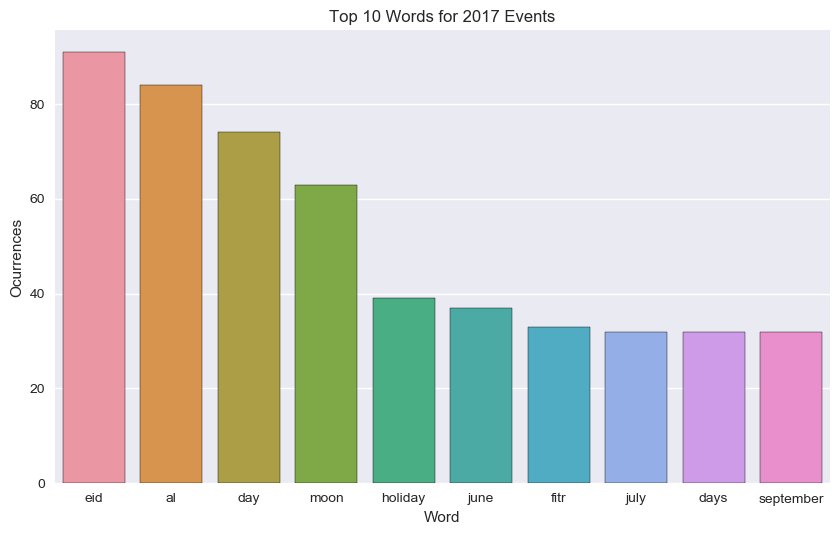

In [21]:
top_10_words_keyword(clean_pages.loc[pd.notnull(clean_pages.news_keywords)],'2017 Events')

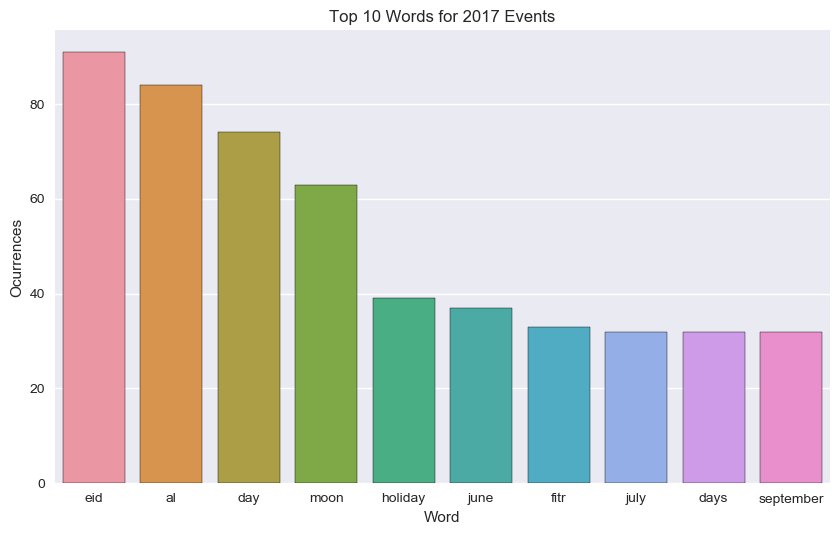

In [22]:
top_10_words_keyword(clean_pages.loc[pd.notnull(clean_pages.news_keywords)],'2017 Events')

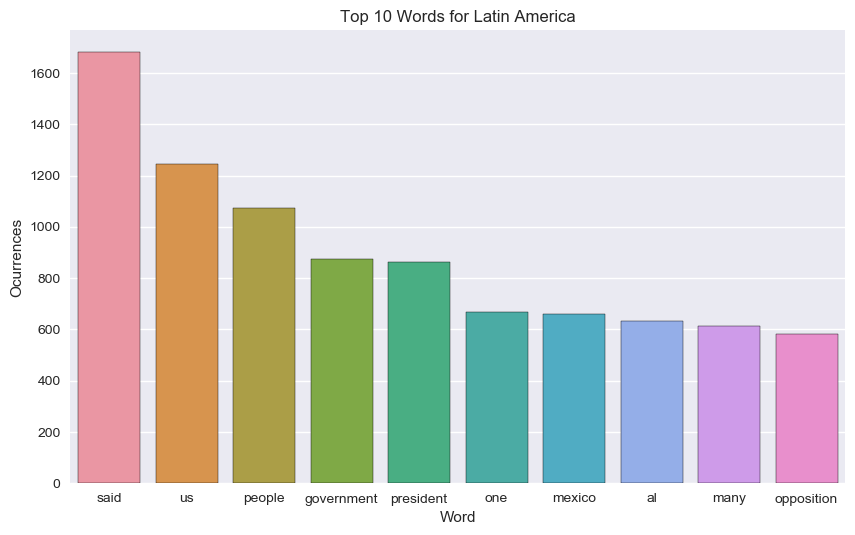

In [23]:
top_10_words_keyword(clean_pages.loc[pd.notnull(clean_pages.news_keywords)],'Latin America')

Let's also look at the top 10 TF-IDF Scores. 

In [24]:
def top_10_tf_idf_keyword(articles,keyword):
    keyword_articles = articles.loc[articles.news_keywords.str.contains(keyword)]
    count_vectorizer = TfidfVectorizer()
    count_vectorizer.fit(keyword_articles.clean_article_body)
    word_count_matrix = count_vectorizer.transform(keyword_articles.clean_article_body)
    word_count_df = pd.DataFrame(word_count_matrix.todense(), columns=count_vectorizer.get_feature_names())
    word_count_sum_df = word_count_df.mean(axis=0).sort_values(ascending=False).reset_index()
    word_count_sum_df.columns = ['Word','TF-IDF']
    plt.title('Top 10 TF-IDF for {}'.format(keyword))
    sns.barplot(x='Word',y='TF-IDF',data=word_count_sum_df.head(10))

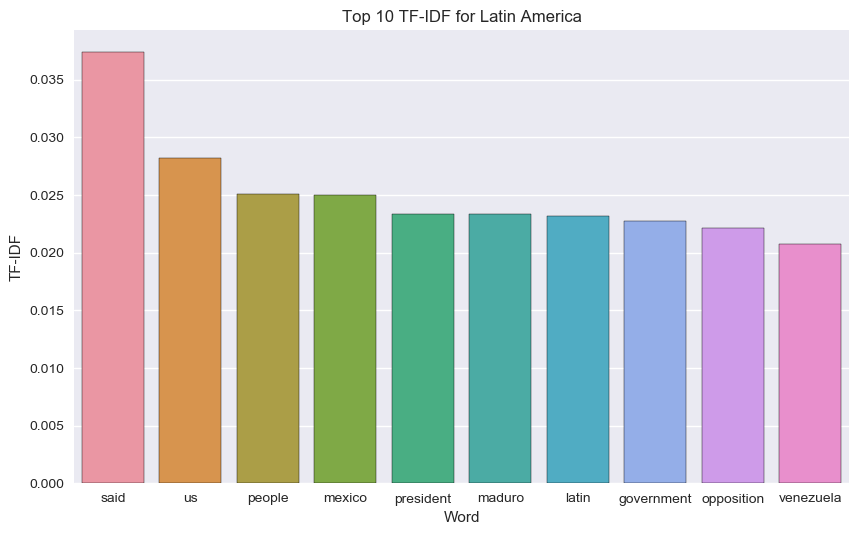

In [25]:
top_10_tf_idf_keyword(clean_pages.loc[pd.notnull(clean_pages.news_keywords)],'Latin America')

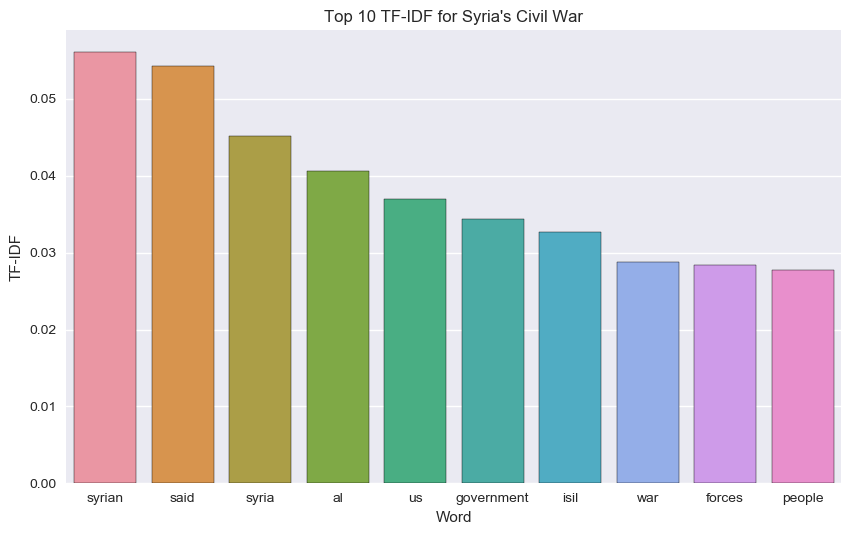

In [26]:
top_10_tf_idf_keyword(clean_pages.loc[pd.notnull(clean_pages.news_keywords)],"Syria's Civil War")

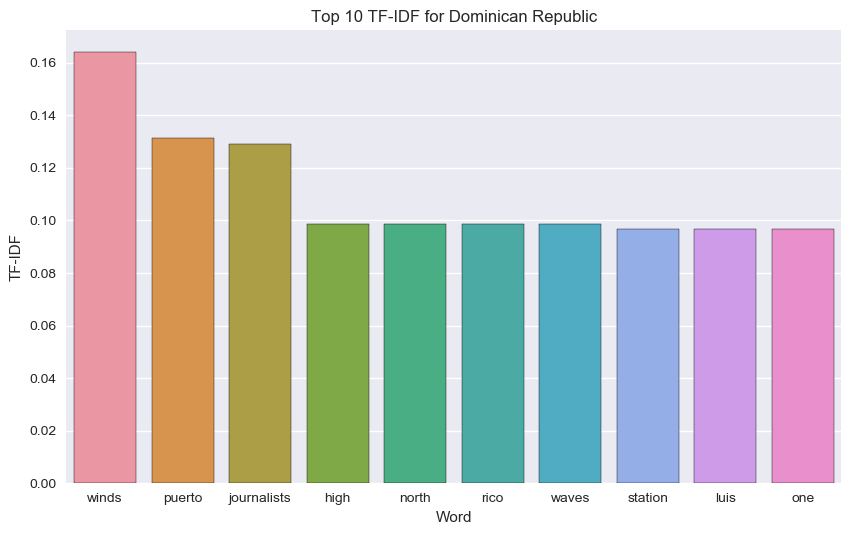

In [27]:
top_10_tf_idf_keyword(clean_pages.loc[pd.notnull(clean_pages.news_keywords)],"Dominican Republic")

Finally, let's take a look at the correlation between keywords. Or, which keywords appear frequently together.

In [28]:
import collections
from itertools import chain
#Separate multiple keywords into unique, separate keywords.
vocabulary = list(map(lambda x: x.lower().split(', '), pages.loc[pd.notnull(pages.news_keywords)].news_keywords))
vocabulary = list(np.unique(list(chain(*vocabulary))))

In [29]:
# Get tag count per article.
keywords_count_vectorizer = CountVectorizer(vocabulary=vocabulary, tokenizer=lambda x: x.split(', '))
X = keywords_count_vectorizer.fit_transform(clean_pages.loc[pd.notnull(clean_pages.news_keywords)].news_keywords)
count_vect_df = pd.DataFrame(X.todense(), columns=keywords_count_vectorizer.get_feature_names())
count_vect_df.head()

,israeli–palestinian conflict,#blackhistorymonth,#freeajstaff,101 east,2017 events,2018 events,abdel fattah el-sisi,abdel-malek al-houthi,abdelaziz bouteflika,abductions,...,xinjiang,yahya jammeh,yasmine ryan,yasser arafat,yazidi,yemen,yugoslavia,zambia,zika virus,zimbabwe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
correlations = count_vect_df.corr()

In [31]:
correlations

,israeli–palestinian conflict,#blackhistorymonth,#freeajstaff,101 east,2017 events,2018 events,abdel fattah el-sisi,abdel-malek al-houthi,abdelaziz bouteflika,abductions,...,xinjiang,yahya jammeh,yasmine ryan,yasser arafat,yazidi,yemen,yugoslavia,zambia,zika virus,zimbabwe
israeli–palestinian conflict,1.000000,-0.003880,-0.002240,-0.001584,-0.005928,-0.005254,0.001961,-0.001584,-0.001584,-0.004480,...,-0.002743,-0.001584,-0.001584,0.048364,-0.003880,-0.028818,-0.003880,-0.007434,-0.002240,-0.019703
#blackhistorymonth,-0.003880,1.000000,-0.000265,-0.000188,-0.000702,-0.000623,-0.001382,-0.000188,-0.000188,-0.000531,...,-0.000325,-0.000188,-0.000188,-0.000188,-0.000460,-0.003415,-0.000460,-0.000881,-0.000265,-0.002335
#freeajstaff,-0.002240,-0.000265,1.000000,-0.000108,-0.000405,-0.000359,-0.000798,-0.000108,-0.000108,-0.000306,...,-0.000188,-0.000108,-0.000108,-0.000108,-0.000265,-0.001971,-0.000265,-0.000508,-0.000153,-0.001348
101 east,-0.001584,-0.000188,-0.000108,1.000000,-0.000287,-0.000254,-0.000564,-0.000077,-0.000077,-0.000217,...,-0.000133,-0.000077,-0.000077,-0.000077,-0.000188,-0.001394,-0.000188,-0.000360,-0.000108,-0.000953
2017 events,-0.005928,-0.000702,-0.000405,-0.000287,1.000000,-0.000951,-0.002111,-0.000287,-0.000287,-0.000811,...,-0.000497,-0.000287,-0.000287,-0.000287,-0.000702,-0.005217,-0.000702,-0.001346,-0.000405,-0.003567
2018 events,-0.005254,-0.000623,-0.000359,-0.000254,-0.000951,1.000000,-0.001871,-0.000254,-0.000254,-0.000719,...,-0.000440,-0.000254,-0.000254,-0.000254,-0.000623,-0.004624,-0.000623,-0.001193,-0.000359,-0.003162
abdel fattah el-sisi,0.001961,-0.001382,-0.000798,-0.000564,-0.002111,-0.001871,1.000000,-0.000564,-0.000564,-0.001596,...,-0.000977,-0.000564,-0.000564,-0.000564,-0.001382,-0.010263,-0.001382,-0.002647,-0.000798,-0.007017
abdel-malek al-houthi,-0.001584,-0.000188,-0.000108,-0.000077,-0.000287,-0.000254,-0.000564,1.000000,-0.000077,-0.000217,...,-0.000133,-0.000077,-0.000077,-0.000077,-0.000188,0.054951,-0.000188,-0.000360,-0.000108,-0.000953
abdelaziz bouteflika,-0.001584,-0.000188,-0.000108,-0.000077,-0.000287,-0.000254,-0.000564,-0.000077,1.000000,-0.000217,...,-0.000133,-0.000077,-0.000077,-0.000077,-0.000188,-0.001394,-0.000188,-0.000360,-0.000108,-0.000953
abductions,-0.004480,-0.000531,-0.000306,-0.000217,-0.000811,-0.000719,-0.001596,-0.000217,-0.000217,1.000000,...,-0.000375,-0.000217,-0.000217,-0.000217,-0.000531,-0.003943,-0.000531,-0.001017,-0.000306,-0.002696


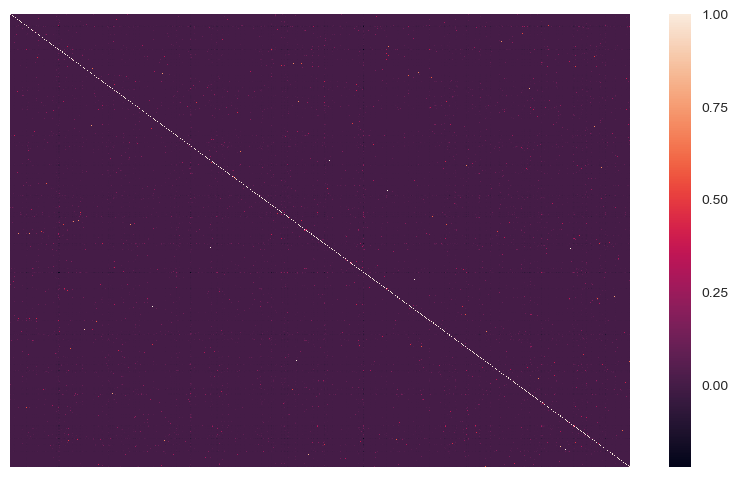

In [32]:
sns.heatmap(correlations,xticklabels=False,yticklabels=False)

Most topics aren't realted to one another, but it can be observed  that several topics have a bit higher correlation with each other. We can see those keywords that have strong correlation by taking a closer look at the data.

In [34]:
high_corr = correlations[correlations > 0.5]
high_corr

,israeli–palestinian conflict,#blackhistorymonth,#freeajstaff,101 east,2017 events,2018 events,abdel fattah el-sisi,abdel-malek al-houthi,abdelaziz bouteflika,abductions,...,xinjiang,yahya jammeh,yasmine ryan,yasser arafat,yazidi,yemen,yugoslavia,zambia,zika virus,zimbabwe
israeli–palestinian conflict,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#blackhistorymonth,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#freeajstaff,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 east,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017 events,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018 events,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abdel fattah el-sisi,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abdel-malek al-houthi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abdelaziz bouteflika,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abductions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
for c in high_corr.columns:
    medium_cor = high_corr[c][high_corr[c] < 1]
    if medium_cor.shape[0] > 0:
        print(c + ":" + str(medium_cor.index.tolist()))
        print(medium_cor.values)

abdullah abdullah:['kabul']
[0.7070797]
addiction:['heroin']
[0.70697134]
afghanistan:['taliban']
[0.54141334]
ahmad shah massoud:['kabul']
[0.7070797]
aids:['hiv']
[0.70702553]
al-shabab:['somalia']
[0.52893657]
answers:['hamza bendelladj']
[0.57730605]
anti-balaka:['seleka']
[0.7070797]
armenia:['nagorno-karabakh']
[0.66653898]
audio:['jetty', 'podcast']
[0.51562018 0.97890746]
balochistan:['quetta attack']
[0.57730605]
bangkok:['obituary']
[0.7070797]
bangladesh national party:['jamaat-e-islami']
[0.7070797]
basketball:['nba']
[0.70702553]
basuki tjahaja purnama:['jakarta', 'joko widodo']
[0.7070797  0.57730605]
benazir bhutto:['bilawal bhutto zardari', 'pervez musharraf']
[0.63238287 0.89439293]
bhumibol adulyadej:['obituary']
[0.7070797]
bhutan:['doklam']
[0.7499234]
bilawal bhutto zardari:['benazir bhutto']
[0.63238287]
boko haram:['nigeria']
[0.59085535]
bomb threats:['pakistan taliban']
[0.57730605]
catalonia:['spain']
[0.78132133]
closer than they appear:['jetty']
[0.70699844]

These combinations of keywords usually go together, and make sense for them to be together like space + NASA, tsunami + fukushima, etc. 

Now that we are done with data visualization, let's move on to preparing the data for modelling.

<a id='preparation'></a>
## Data Preparation

Machine Learning models only take numbers as input. This means we have to convert our articles, which are composed of text, into numbers. To perform this task, there are several methods, such as: 

- Counting the number of appearances of each unique word in each article. This leaves us with a matrix in which each value represents the number of times a word appears in the article. 

- TF-IDF. Assign scores to each word, base on how common they are on a specific article, and how uncommon they are accross all articles as a whole. 

For this problem we'll use TF-IDF, since in practice it usually performs better than just a word count. To create the TF-IDF matrix, we first have to assign the limits of the percentage of frequency of words. This prevents words that are too rare (words that appear only once or twice), or words that appear too frequently from being included into the matrix. We first have to split the data into a training set, by only using the articles that have keywords.

Let's limit the number of keywords to use in training. Some keywords appear very infrequently, less than 20 times, and will only add noise to the model and metrics. We first visualize the statistics for the counts of keywords.

In [36]:
keyword_count = count_vect_df.sum(axis=0)
keyword_count.describe()

count     799.000000
mean       62.911139
std       256.466193
min         1.000000
25%         2.000000
50%         8.000000
75%        28.000000
max      4235.000000
dtype: float64

These statistics denote on how many articles each keyword appears. For example, the median article appearances for all keywords is 8, while the mean is 62.9. This means there are several keywords that have  a very high count. Let's check the distribution of the keyword counts.

Text(0.5,1,'Keyword Count Distribution')

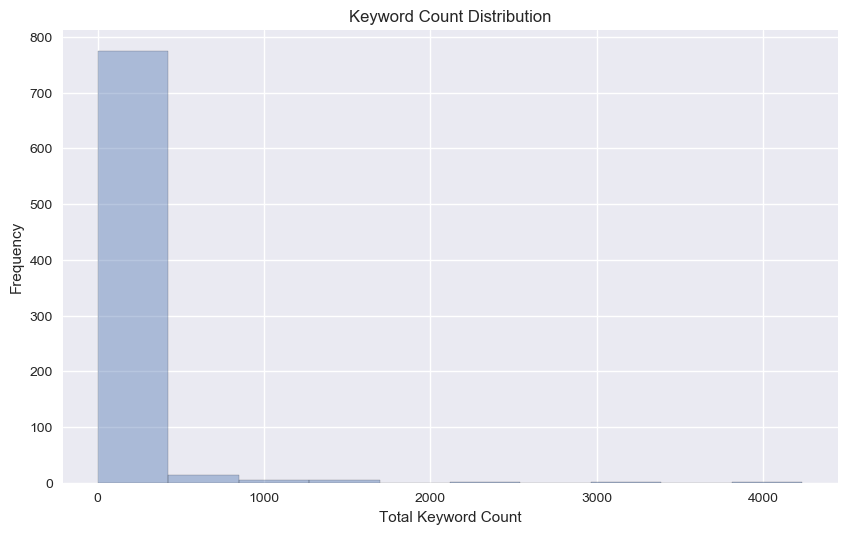

In [37]:
sns.distplot(keyword_count,bins=10,kde=False)
plt.xlabel('Total Keyword Count')
plt.ylabel('Frequency')
plt.title('Keyword Count Distribution')

It can be seen that most keywords, appear less than 500 times, however there are a few keywords that appear very frequently, which skew the distribution. We can take a more specific look at the keywords, limiting them to those that appear less than 1000 times.

Text(0.5,1,'Keyword Count Distribution')

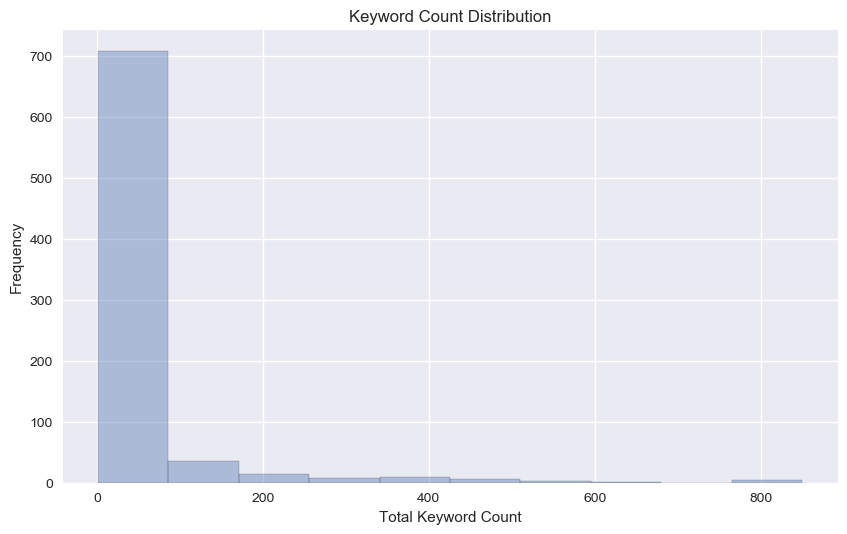

In [38]:
sns.distplot(keyword_count[keyword_count < 1000],bins=10,kde=False)
plt.xlabel('Total Keyword Count')
plt.ylabel('Frequency')
plt.title('Keyword Count Distribution')

A similar distribution appears, where most keywords have low counts. If we keep zooming in, the same distribution is visible, where low keyword counts predate the dataset. We can take a look at the top keywords:

middle east       4235
politics          3055
united states     2431
europe            1651
us & canada       1639
asia              1451
africa            1357
human rights      1228
war & conflict    1219
asia pacific      1094
dtype: int64


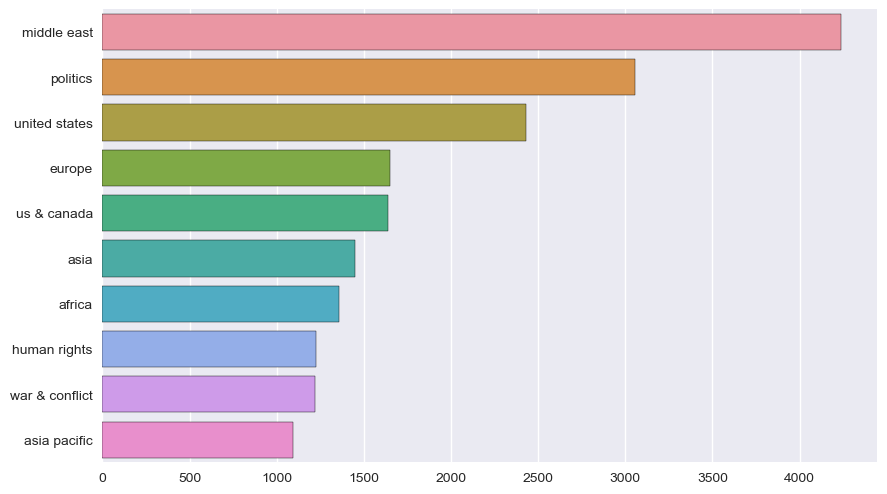

In [39]:
top_10_keywords = keyword_count.sort_values(ascending=False).head(10)
print(top_10_keywords)
sns.barplot(x=top_10_keywords.values,y=top_10_keywords.index)

Then, let's separate them into easy to understand bins. 

In [40]:
kw_count_bins = pd.cut(keyword_count,bins=[0,10,20,50,100,250,500,1000,5000])
kw_counts_df = pd.DataFrame(kw_count_bins.value_counts())
kw_counts_df.columns=['Count']
kw_counts_df['Cumulative_Count'] = kw_counts_df.Count.cumsum()
kw_counts_df['Cumulative_Percent'] = kw_counts_df.Cumulative_Count / kw_counts_df.Count.sum()
kw_counts_df

,Count,Cumulative_Count,Cumulative_Percent
"(0, 10]",458,458,0.573217
"(20, 50]",103,561,0.702128
"(10, 20]",102,663,0.829787
"(50, 100]",51,714,0.893617
"(100, 250]",43,757,0.947434
"(250, 500]",22,779,0.974969
"(1000, 5000]",10,789,0.987484
"(500, 1000]",10,799,1.000000


As it can be observed, 82% of the keywords  appear in 20 articles or less. This small number of examples for each may not be sufficient for the model, and only add noise, so they are removed.

In [41]:
train_keywords = keyword_count[keyword_count > 20].index
len(train_keywords)

239

In [42]:
total_keywords = count_vect_df[train_keywords].sum(axis=1)
valid_train_keywords = total_keywords[total_keywords > 0].index

In [43]:
training_data = clean_pages.loc[pd.notnull(clean_pages.news_keywords)].reset_index(drop=True)
training_data = training_data.loc[valid_train_keywords].reset_index(drop=True)
print("The training data contains {} articles".format(training_data.shape[0]))
training_data.head()

The training data contains 13041 articles


,title,description,article_body,news_keywords,last_modified_date,Week,Month,clean_article_body
0,Reporters Without Borders: Journalism at tippi...,Reporters Without Borders warns of tipping poi...,Media freedom is being undermined by the rise ...,"Press Freedom, Media",2017-04-26 09:46:36,17.0,4.0,media freedom undermined rise surveillance aut...
1,Israeli forces raid village of driver who kill...,Israel suspends work permits of at least 100 m...,The incident happened as other confrontations ...,"Occupied West Bank, Israeli–Palestinian confl...",2018-03-17 09:26:05,11.0,3.0,incident happened confrontations palestinians ...
2,Eastern Ghouta shelled despite 'truce agreement',UK-based monitoring group says Syrian governme...,A wounded man is seen in a hospital in Douma a...,"Bashar al-Assad, Syria's Civil War, Middle Eas...",2017-11-29 21:03:09,48.0,11.0,wounded man seen hospital douma air raid file ...
3,Middle-aged Palestinian woman shot dead in Jer...,Israeli officers gun down mother of Palestinia...,Human rights groups have accused Israeli secur...,"Middle East, Jerusalem, Palestine",2017-03-29 18:17:59,13.0,3.0,human rights groups accused israeli security f...
4,Brazil congress to vote on whether to remove p...,Brazil's President Michel Temer denies allegat...,If two-thirds of legislators in Brazils Lower ...,"Latin America, Brazil",2017-08-02 01:20:21,31.0,8.0,two thirds legislators brazils lower house vot...


In [44]:
week_month = training_data[['Week','Month']]
week_month_dummies_df = pd.get_dummies(week_month,prefix=['Week','Month'],columns=['Week','Month'])
week_month_dummies=  week_month_dummies_df.values

In [45]:
TfIdfVect = TfidfVectorizer(min_df=0.02,max_df=0.2)
TfIdfVect.fit(training_data.clean_article_body)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.2, max_features=None, min_df=0.02,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

We can inspect the size of the vocabulary created.

In [46]:
print("The vocabulary contains {} distinct words.".format(len(TfIdfVect.get_feature_names())))

The vocabulary contains 2051 distinct words.


We can use this vectorizer created to convert the cleaned articles into a tf-idf matrix.

In [47]:
score_matrix = TfIdfVect.transform(training_data.clean_article_body)
score_matrix.shape

(13041, 2051)

Finally, we'll use the tag count matrix created earlier, to assign our training data and training labels.

In [48]:
x_train = score_matrix.todense()
y_train = count_vect_df[train_keywords].loc[valid_train_keywords].values

With our data created, we can proceed to modelling. 

<a id='model'></a>
## Modelling

As mentioned previously, the models we can use are limited to those that support multilabel classification in a light way. By this, it means that we don't have to use multiple One Vs Rest classifiers to create the model. Using multiple One Vs Rest classifiers is very computationally inefficient, because this entails creating one model per keyword, then using all models during prediction time. This means training a large number of models, which will only increase in number when the number of keywords increase. Due to these limitations, we decided on three posible classifiers: 

- Random Forests: Creates multiple decision trees, statistical data structures that split the data according to criteria which divide the label best, and averages them to create a more balanced prediction. 

- K-Nearest Neighbors: Assigns points to the data, compares them using a distance metric, and assigns a classification based on the labels of the nearest points. 

- Neural Network: Computes several matrix multiplications to approximate a function from its input to its output. 

All of these support multilabel classification from the get go. However, for Random Forests and KNN, it's better to apply a dimensionality reduction technique to the data before training. Neural Networks work better with high dimensional data, so for these models this step isn't needed. For the dimensionality reduction algorithm, we'll use Principal Component Analysis (PCA), which maps higher dimensional data into a lower dimension, by trying to minimize the variance between the data in a higher dimension and its possible lower dimension. Let's apply it to the TF-IDF matrix we created previously and create a new $sqrt(n)$ dimensional matrix, where n stands for the number of variables in the current, non-reduced matrix.

In [43]:
pca_x_train = PCA(n_components=np.sqrt(x_train.shape[1]).astype(int)).fit_transform(x_train)
pca_x_train.shape

(13041, 45)

Now, let's use cross validation, and the weighted f1 score, to evaluate these models. 

#### KNN 

In [166]:
clf = KNeighborsClassifier(n_jobs = 8)
knn_scores = cross_val_score(clf, pca_x_train, y_train, cv=5, scoring='f1_weighted',verbose=5)
print(knn_scores)
print("Average KNN F1 Score: {}".format(knn_scores.mean()))

[CV]  ................................................................
[CV] ....................... , score=0.5430060798520033, total=   0.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ....................... , score=0.5570847925501659, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] ....................... , score=0.5569343159330967, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s


[CV] ....................... , score=0.5512932292859026, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.5s remaining:    0.0s


[CV] ....................... , score=0.5447637645359147, total=   0.6s
[0.54300608 0.55708479 0.55693432 0.55129323 0.54476376]
Average KNN F1 Score: 0.5506164364314167


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished


#### Random Forest

In [47]:
dtree = RandomForestClassifier(n_jobs=4)
tree_scores = cross_val_score(dtree, pca_x_train, y_train, cv=5, scoring='f1_weighted')
tree_scores

array([0.41971476, 0.43467355, 0.43035689, 0.42683596, 0.41643455])

In [48]:
print("Mean Random Forest F1 Score: {}".format(tree_scores.mean()))

Mean Random Forest F1 Score: 0.4256031433442284


#### Neural Network 

For the Neural Network, we'll use the Keras library to easily create a NN architecture. We'll also create a custom class, to cross validate and evaluate the neural network, since Keras doesn't support scikit-learn levels of cross validation by default.

In [52]:
class Metrics(Ke.callbacks.Callback):
    """
    Helper class to compute evaluation metrics for the Keras neural networks.
    """
    
    
    def prepare_metrics_dict(self,logs={}):
        dic=dict()
        dic['precision'] = list()
        dic['f1s'] = list()
        dic['recall'] = list()
        return dic
    
    def on_train_begin(self, logs={}):
        self.train_dict=self.prepare_metrics_dict()
        self.val_dict=self.prepare_metrics_dict()

    def get_metrics(self,model,dic,x,y):
        score = np.asarray(model.predict(x))
        predict = np.round(np.asarray(self.model.predict(self.validation_data[0])))
        targ = self.validation_data[1]
        dic['precision'].append(sklm.precision_score(targ, predict,average='weighted'))
        dic['recall'].append(sklm.recall_score(targ, predict,average='weighted'))
        dic['f1s'].append(sklm.f1_score(targ, predict,average='weighted'))
        
    def on_epoch_end(self, epoch, logs={}):
        x_val,y_val = (self.validation_data[0],self.validation_data[1])
        self.get_metrics(self.model,self.val_dict,x_val,y_val)

        return

In [53]:
class KerasModel(object):
    """
    Helper class to instantiate, train and evaluate a Keras Neural Network
    """
    def __init__(self,X,y,params_dict,n_folds=5):
        self.X = X
        self.y = y
        self.metrics=dict()
        self.n_folds=n_folds
        self.params_dict=params_dict
    
    def init_metrics(self):
        dic=dict()
        dic['precision'] = list()
        dic['f1s'] = list()
        dic['recall'] = list()
        return dic
    
    def create_model(self,params_dict):
        model = Sequential()
        #Input layer + Hidden Layer
        model.add(Dense(params_dict['layer_1_units'], input_shape=(self.X.shape[1],),kernel_initializer='glorot_normal'))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        
        model.add(Dense(params_dict['layer_1_units'] // 2,kernel_initializer='glorot_normal'))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        
        
        model.add(Dense(self.y.shape[1],kernel_initializer='glorot_normal'))
        model.add(BatchNormalization())
        model.add(Activation('sigmoid'))
        model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])
        self.model = model
    
    def calculate_metrics(self,model,metrics_dict,x_val,y_val):
        score = np.asarray(model.predict(x_val))
        predict = np.round(np.asarray(self.model.predict(x_val)))
        targ = y_val
        metrics_dict['precision'].append(sklm.precision_score(targ, predict,average='weighted'))
        metrics_dict['recall'].append(sklm.recall_score(targ, predict,average='weighted'))
        metrics_dict['f1s'].append(sklm.f1_score(targ, predict,average='weighted'))
        print("F1 Score: {}".format(sklm.f1_score(targ, predict,average='weighted')))
        
    
    def train_and_evaluate_model(self,model,metrics_obj,metrics_dict,params_dict,x_train, y_train, x_val, y_val):
        history = model.fit(x_train, y_train, 
                        batch_size=params_dict['batch_size'], 
                        epochs=params_dict['epochs'], 
                        verbose=1)
        self.calculate_metrics(model,metrics_dict,x_val,y_val)
    
    
    def model_cross_validation(self):
        skf = KFold(n_splits=self.n_folds, shuffle=True)
        self.metrics = self.init_metrics()
        i = 0
        for train, test in skf.split(self.X, self.y):
            print ("Running Fold", i + 1, "/", self.n_folds)
            self.model = None # Clearing the NN.
            self.create_model(self.params_dict)
            metrics_obj = Metrics()
            self.train_and_evaluate_model(self.model,metrics_obj,self.metrics,self.params_dict
                                          , self.X[train], self.y[train], self.X[test], self.y[test])
            i+=1
    
    def train_final_model(self):
        self.model = None
        self.create_model(self.params_dict)
        history = self.model.fit(self.X, self.y, 
                            batch_size=self.params_dict['batch_size'], 
                            epochs=self.params_dict['epochs'], 
                            verbose=1)

In [49]:
params_dict = {
    'epochs':2,
    'batch_size':16,
    'layer_1_units':1024
}

In [167]:
keras_model = KerasModel(np.concatenate((score_matrix.todense(),week_month_dummies),axis=1),y_train,params_dict)
keras_model.model_cross_validation()

Running Fold 1 / 5
Epoch 1/2
10432/10432 [==============================] - 32s 3ms/step - loss: 0.6000 - acc: 0.7399
Epoch 2/2
10432/10432 [==============================] - 30s 3ms/step - loss: 0.3640 - acc: 0.9746
F1 Score: 0.6333495997756573
Running Fold 2 / 5
Epoch 1/2
10433/10433 [==============================] - 31s 3ms/step - loss: 0.5998 - acc: 0.7479
Epoch 2/2
10433/10433 [==============================] - 30s 3ms/step - loss: 0.3635 - acc: 0.9743
F1 Score: 0.6211792441465003
Running Fold 3 / 5
Epoch 1/2
10433/10433 [==============================] - 30s 3ms/step - loss: 0.5997 - acc: 0.7457
Epoch 2/2
10433/10433 [==============================] - 30s 3ms/step - loss: 0.3634 - acc: 0.9747
F1 Score: 0.62310018092492
Running Fold 4 / 5
Epoch 1/2
10433/10433 [==============================] - 30s 3ms/step - loss: 0.5999 - acc: 0.7445
Epoch 2/2
10433/10433 [==============================] - 30s 3ms/step - loss: 0.3637 - acc: 0.9751
F1 Score: 0.6255475256988758
Running Fold 5 / 5

In [168]:
for metric,score_list in keras_model.metrics.items():
    print("Average {}: {}".format(metric,np.array(score_list).mean()))

Average precision: 0.6768937322555418
Average f1s: 0.6273566603329997
Average recall: 0.6119621513911968


In [ ]:
gc.collect()

Let's also compare NN with different feature sets.

In [47]:
pages.head()

,title,description,article_body,news_keywords,clean_article_body
0,The chronicler of Indian food,"For 40 years, food historian Pushpesh Pant has...","Delhi, India - It is a winter afternoon and th...",NaN,delhi india winter afternoon food historian dr...
1,Reporters Without Borders: Journalism at tippi...,Reporters Without Borders warns of tipping poi...,Media freedom is being undermined by the rise ...,"Press Freedom, Media",media freedom undermined rise surveillance aut...
2,Israeli forces raid village of driver who kill...,Israel suspends work permits of at least 100 m...,The incident happened as other confrontations ...,"Occupied West Bank, Israeli–Palestinian confl...",incident happened confrontations palestinians ...
3,Eastern Ghouta shelled despite 'truce agreement',UK-based monitoring group says Syrian governme...,A wounded man is seen in a hospital in Douma a...,"Bashar al-Assad, Syria's Civil War, Middle Eas...",wounded man seen hospital douma air raid file ...
4,Middle-aged Palestinian woman shot dead in Jer...,Israeli officers gun down mother of Palestinia...,Human rights groups have accused Israeli secur...,"Middle East, Jerusalem, Palestine",human rights groups accused israeli security f...


So far the NN has been outperforming. Let's continue to use it for further comparison. Let's compare different text features to assess their performance. The ones used will be: 

- Only title.
- Title + Description.
- Title + Description + Body.

In [50]:
def create_full_text_data(data,text_type):
    if text_type == 'title':
        return data['title']
    elif text_type == 'title_description':
        return data['title'] + ' ' + data['description']
    elif text_type == 'title_description_body':
        return data['title'] + ' ' + data['description'] + ' ' + data['article_body']
    
    else:
        return None

def NN_text_feature_comparison(data,params):
    text_data_list = ['title','title_description','title_description_body']
    feature_size_list= [[0.001,0.8],[0.002,0.5],[0.02,0.2]]
    training_data = data.loc[pd.notnull(data.news_keywords)].reset_index(drop=True)
    training_data = training_data.loc[valid_train_keywords].reset_index(drop=True)
    best_training_data = None
    best_score = 0
    for i,text in enumerate(text_data_list):
        print("Creating NN model for {}".format(text))
        text_body = create_full_text_data(training_data,text)
        cleaned_text_body = text_body.apply(Clean_Text)
        cleaned_text_body = cleaned_text_body
        TfIdfVect = TfidfVectorizer(min_df=feature_size_list[i][0],max_df=feature_size_list[i][1])
        TfIdfVect.fit(cleaned_text_body)
        score_matrix = TfIdfVect.transform(cleaned_text_body)
        print("Training Data Shape: {},{}".format(score_matrix.shape[0],score_matrix.shape[1]))
        keras_model = KerasModel(np.concatenate((score_matrix.todense(),week_month_dummies),axis=1),y_train,params)
        keras_model.model_cross_validation()
        f1_score = np.array(keras_model.metrics['f1s']).mean()
        for metric,score_list in keras_model.metrics.items():
            print("Average {}: {}".format(metric,np.array(score_list).mean()))
        
        if f1_score > best_score:
            best_training_data = score_matrix
            best_score = f1_score
    
    print("F1 Score: {}".format(best_score))
    return best_score,best_training_data

In [51]:
best_score,best_data = NN_text_feature_comparison(pages,params_dict)

Creating NN model for title
Training Data Shape: 13041,1140
Running Fold 1 / 5
Epoch 1/2
10432/10432 [==============================] - 23s 2ms/step - loss: 0.6042 - acc: 0.7254
Epoch 2/2
10432/10432 [==============================] - 23s 2ms/step - loss: 0.3656 - acc: 0.9747
F1 Score: 0.5740121425380091
Running Fold 2 / 5
Epoch 1/2
10433/10433 [==============================] - 24s 2ms/step - loss: 0.6040 - acc: 0.7287
Epoch 2/2
10433/10433 [==============================] - 23s 2ms/step - loss: 0.3654 - acc: 0.9744
F1 Score: 0.572872187502674
Running Fold 3 / 5
Epoch 1/2
10433/10433 [==============================] - 24s 2ms/step - loss: 0.6042 - acc: 0.7249
Epoch 2/2
10433/10433 [==============================] - 22s 2ms/step - loss: 0.3655 - acc: 0.9745
F1 Score: 0.5701001279199884
Running Fold 4 / 5
Epoch 1/2
10433/10433 [==============================] - 23s 2ms/step - loss: 0.6040 - acc: 0.7303
Epoch 2/2
10433/10433 [==============================] - 22s 2ms/step - loss: 0.3653 

In [ ]:
keras_model = KerasModel(best_data,y_train,params_dict)
keras_model.train_final_model()

Since we are also interested in assessing how good the model is in the future, let's also train a NN with only 2017 data, and test it with 2018 data.

In [70]:
original_pages =  pd.read_csv('aje_ga_pages_with_meta_and_body.csv')
original_pages.shape

(21709, 11)

In [48]:
original_pages =  pd.read_csv('aje_ga_pages_with_meta_and_body.csv')
original_pages = original_pages.loc[pd.notnull(original_pages.news_keywords)].reset_index(drop=True)
original_pages.head()

,Unnamed: 0,url,title,path,html_file_name,description,news_keywords,content_type,last_modified_date,article_body,keywords
0,www.aljazeera.com/news/2017/04/reports-borders...,http://www.aljazeera.com/news/2017/04/reports-...,Reporters Without Borders: Journalism at tippi...,/news/2017/04/reports-borders-journalism-tippi...,html_files/64efe6c26edb72c02672d928ef0b91caa17...,Reporters Without Borders warns of tipping poi...,"Press Freedom, Media",News,"Wed, 26 April 2017 09:46:36 GMT",Media freedom is being undermined by the rise ...,NaN
1,www.aljazeera.com/news/2018/03/israeli-forces-...,http://www.aljazeera.com/news/2018/03/israeli-...,Israeli forces raid village of driver who kill...,/news/2018/03/israeli-forces-raid-village-driv...,html_files/56153dbfe8ea391400478ea1cc3c9bc61af...,Israel suspends work permits of at least 100 m...,"Occupied West Bank, Israeli–Palestinian confl...",News,"Sat, 17 March 2018 09:26:05 GMT",The incident happened as other confrontations ...,NaN
2,www.aljazeera.com/news/2017/11/eastern-ghouta-...,http://www.aljazeera.com/news/2017/11/eastern-...,Eastern Ghouta shelled despite 'truce agreement',/news/2017/11/eastern-ghouta-shelled-truce-agr...,html_files/d72d1ab5c85056866aabe427232776d0870...,UK-based monitoring group says Syrian governme...,"Bashar al-Assad, Syria's Civil War, Middle Eas...",News,"Wed, 29 November 2017 21:03:09 GMT",A wounded man is seen in a hospital in Douma a...,NaN
3,www.aljazeera.com/news/2017/03/middle-aged-pal...,http://www.aljazeera.com/news/2017/03/middle-a...,Middle-aged Palestinian woman shot dead in Jer...,/news/2017/03/middle-aged-palestinian-woman-sh...,html_files/9207a8046309a44623b4931ff23638ad62f...,Israeli officers gun down mother of Palestinia...,"Middle East, Jerusalem, Palestine",News,"Wed, 29 March 2017 18:17:59 GMT",Human rights groups have accused Israeli secur...,NaN
4,www.aljazeera.com/news/2017/08/brazil-congress...,http://www.aljazeera.com/news/2017/08/brazil-c...,Brazil congress to vote on whether to remove p...,/news/2017/08/brazil-congress-vote-remove-pres...,html_files/63fb85a5f1788e769fd78e0b3cb43c8180e...,Brazil's President Michel Temer denies allegat...,"Latin America, Brazil",News,"Wed, 02 August 2017 01:20:21 GMT",If two-thirds of legislators in Brazils Lower ...,NaN


In [49]:
original_pages.last_modified_date = pd.to_datetime(original_pages.last_modified_date)
original_pages = original_pages.loc[valid_train_keywords].reset_index(drop=True)
original_pages.shape

(13041, 11)

In [50]:
news_2017 = original_pages.loc[original_pages.last_modified_date.dt.year == 2017]
news_2018 = original_pages.loc[original_pages.last_modified_date.dt.year == 2018]
news_2017.head()

,Unnamed: 0,url,title,path,html_file_name,description,news_keywords,content_type,last_modified_date,article_body,keywords
0,www.aljazeera.com/news/2017/04/reports-borders...,http://www.aljazeera.com/news/2017/04/reports-...,Reporters Without Borders: Journalism at tippi...,/news/2017/04/reports-borders-journalism-tippi...,html_files/64efe6c26edb72c02672d928ef0b91caa17...,Reporters Without Borders warns of tipping poi...,"Press Freedom, Media",News,2017-04-26 09:46:36,Media freedom is being undermined by the rise ...,NaN
2,www.aljazeera.com/news/2017/11/eastern-ghouta-...,http://www.aljazeera.com/news/2017/11/eastern-...,Eastern Ghouta shelled despite 'truce agreement',/news/2017/11/eastern-ghouta-shelled-truce-agr...,html_files/d72d1ab5c85056866aabe427232776d0870...,UK-based monitoring group says Syrian governme...,"Bashar al-Assad, Syria's Civil War, Middle Eas...",News,2017-11-29 21:03:09,A wounded man is seen in a hospital in Douma a...,NaN
3,www.aljazeera.com/news/2017/03/middle-aged-pal...,http://www.aljazeera.com/news/2017/03/middle-a...,Middle-aged Palestinian woman shot dead in Jer...,/news/2017/03/middle-aged-palestinian-woman-sh...,html_files/9207a8046309a44623b4931ff23638ad62f...,Israeli officers gun down mother of Palestinia...,"Middle East, Jerusalem, Palestine",News,2017-03-29 18:17:59,Human rights groups have accused Israeli secur...,NaN
4,www.aljazeera.com/news/2017/08/brazil-congress...,http://www.aljazeera.com/news/2017/08/brazil-c...,Brazil congress to vote on whether to remove p...,/news/2017/08/brazil-congress-vote-remove-pres...,html_files/63fb85a5f1788e769fd78e0b3cb43c8180e...,Brazil's President Michel Temer denies allegat...,"Latin America, Brazil",News,2017-08-02 01:20:21,If two-thirds of legislators in Brazils Lower ...,NaN
5,www.aljazeera.com/indepth/opinion/2017/04/list...,http://www.aljazeera.com/indepth/opinion/2017/...,I listen to refugees and I hear my own story,/indepth/opinion/2017/04/listen-refugees-hear-...,html_files/04fa7206171c14d5d2762304172f322c0fd...,The thoughts of a former European refugee on h...,"Refugees, Greece, Human Rights, Europe",Opinion,2017-04-12 07:59:17,more on RefugeesEstimated 60 percent o...,NaN


In [51]:
y_2017 = count_vect_df[train_keywords].loc[valid_train_keywords].reset_index(drop=True).loc[news_2017.index]
y_2018 = count_vect_df[train_keywords].loc[valid_train_keywords].reset_index(drop=True).loc[news_2018.index]
y_2017.shape

(9013, 239)

Let's explore how these keywords change from one year to the next. Since our model will need to adapt to keywords changing over time, we need to explore how these keywords change over time. Let's create a bubble chart to explore this.

In [52]:
year_word_count = pd.DataFrame({'Keyword':y_2017.columns,'Count_2017':y_2017.sum(axis=0).values,
             'Count_2018':y_2018.sum(axis=0).values})
year_word_count['Total_Count'] = year_word_count['Count_2017'] + year_word_count['Count_2018']

In [89]:
trace = go.Scatter(
    x=year_word_count.Count_2017.tolist(),
    y=year_word_count.Count_2018.tolist(),
    text=(year_word_count.Keyword + ':' + year_word_count.Total_Count.astype(str) ).tolist(),
    mode='markers',
)

layout = go.Layout(
        title='Keyword Count 2017 vs. 2018',
         xaxis=dict(
            title='Count 2017',
            titlefont=dict(
                family='Myriad',
                size=20,
            ),
             showticklabels=True
        ),
         yaxis=dict(
            title='Count 2018',
            titlefont=dict(
                family='Myriad',
                size=20,
            )
        )
    )

data = [trace]
fig = go.Figure(data=data,layout=layout)
ipy(fig, config=plotly_config)

As it can be visualized, some keywords appear much less frequently from one year to the next. This is because some topics (for example Puerto Rico from the hurricane in 2017), aren't as relevant when the years go on, in contrast with topics like politics, which stay throughout time. To combat this, the production model will check for keyword counts in the past year, and use only those that appear frequently in the whole year, with more emphasis on those that appear recently, as long as there's enough data about them.

We need to make sure to actually use keywords that appear in both years.

In [62]:
time_keywords= count_vect_df[train_keywords].sum(axis=0)
time_keywords = time_keywords[(y_2017.sum(axis=0) > 0 ) & (y_2018.sum(axis=0) > 0 )]
time_keywords.index

Index([' israeli–palestinian conflict', 'abdel fattah el-sisi', 'abuse',
       'afghanistan', 'africa', 'aid', 'al jazeera', 'al-aqsa mosque',
       'al-qaeda', 'al-shabab',
       ...
       'vladimir putin', 'war', 'war & conflict', 'water', 'weather',
       'women's rights', 'xi jinping', 'yemen', 'zambia', 'zimbabwe'],
      dtype='object', length=232)

In [63]:
y_2017 = y_2017[time_keywords.index]
y_2018 = y_2018[time_keywords.index]

In [50]:
training_data['clean_article_body'] = training_data['title'] + ' ' + training_data['description'] + ' ' + training_data['article_body']
training_data.clean_article_body = training_data.clean_article_body.apply(Clean_Text)
training_data.head()

,title,description,article_body,news_keywords,last_modified_date,Week,Month,clean_article_body
0,Reporters Without Borders: Journalism at tippi...,Reporters Without Borders warns of tipping poi...,Media freedom is being undermined by the rise ...,"Press Freedom, Media",2017-04-26 09:46:36,17.0,4.0,reporters without borders journalism tipping p...
1,Israeli forces raid village of driver who kill...,Israel suspends work permits of at least 100 m...,The incident happened as other confrontations ...,"Occupied West Bank, Israeli–Palestinian confl...",2018-03-17 09:26:05,11.0,3.0,israeli forces raid village driver killed two ...
2,Eastern Ghouta shelled despite 'truce agreement',UK-based monitoring group says Syrian governme...,A wounded man is seen in a hospital in Douma a...,"Bashar al-Assad, Syria's Civil War, Middle Eas...",2017-11-29 21:03:09,48.0,11.0,eastern ghouta shelled despite truce agreement...
3,Middle-aged Palestinian woman shot dead in Jer...,Israeli officers gun down mother of Palestinia...,Human rights groups have accused Israeli secur...,"Middle East, Jerusalem, Palestine",2017-03-29 18:17:59,13.0,3.0,middle aged palestinian woman shot dead jerusa...
4,Brazil congress to vote on whether to remove p...,Brazil's President Michel Temer denies allegat...,If two-thirds of legislators in Brazils Lower ...,"Latin America, Brazil",2017-08-02 01:20:21,31.0,8.0,brazil congress vote whether remove president ...


In [65]:
training_2017 = training_data.loc[news_2017.index]
test_2018 = training_data.loc[news_2018.index]

In [66]:
TfIdfVect = TfidfVectorizer(min_df=0.02,max_df=0.2)
TfIdfVect.fit(training_2017.clean_article_body)
score_matrix_2017 = TfIdfVect.transform(training_2017.clean_article_body)
score_matrix_2018 = TfIdfVect.transform(test_2018.clean_article_body)

Training the model and assessing it.

In [67]:
keras_model = KerasModel(score_matrix_2017,y_2017,params_dict)
keras_model.train_final_model()

Epoch 1/2
9013/9013 [==============================] - 34s 4ms/step - loss: 0.6174 - acc: 0.7193
Epoch 2/2
9013/9013 [==============================] - 33s 4ms/step - loss: 0.3962 - acc: 0.9668


In [68]:
preds_2018 = np.round(keras_model.model.predict(score_matrix_2018)).astype(int)
preds_2018

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [69]:
print("2018 F1 Score only training with 2017 data: {}".format(sklm.f1_score(y_2018,preds_2018,average='weighted')))

2018 F1 Score only training with 2017 data: 0.6250728333369273


Nice, the model has a decent F1 Score, even on unseen, future data! However, one limitation is that we can't predict keywords that aren't present in the future year.

One more comparison to make, is using different feature vector generators like: 

- TF or Term Frequency. Simple Term frequency.
- TF-IDF or Term Frequency Inverse Document Frequency.
- Doc2Vec


In [68]:
def create_full_text_vector(data,vector_type):
    if vector_type == 'tf':
        CountVect = CountVectorizer(min_df=0.02,max_df=0.2)
        CountVect.fit(data.clean_article_body)
        score_matrix = CountVect.transform(data.clean_article_body)
        score_matrix = score_matrix.todense()
        
    elif vector_type == 'tfidf':
        TfIdfVect = TfidfVectorizer(min_df=0.02,max_df=0.2)
        TfIdfVect.fit(data.clean_article_body)
        score_matrix = TfIdfVect.transform(data.clean_article_body)
        score_matrix = score_matrix.todense()
    elif vector_type == 'doc2vec':
        doc_2vec_input = list()
        LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
        for i in range(data.shape[0]):
            doc_2vec_input.append(LabeledSentence1(data.clean_article_body.iloc[i].split(),[i]))
        
        d2v_model = Doc2Vec(doc_2vec_input, vector_size = 2000, window = 20, min_count = 10, workers=8, dm = 0,seed=777)
        doc_vecs = d2v_model.docvecs
        d2v_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
        score_matrix = doc_vecs.doctag_syn0   

    else:
        return None
    return score_matrix

In [69]:
def NN_feature_vector_comparison(data,params):
    text_data_list = ['tf','tfidf','doc2vec']
    best_score = 0
    best_feature_vector = None
    for i,text in enumerate(text_data_list):
        print("Creating NN model for {}".format(text))
        score_matrix = create_full_text_vector(data,text)
        print("Training Data Shape: {},{}".format(score_matrix.shape[0],score_matrix.shape[1]))
        keras_model = KerasModel(np.concatenate((score_matrix,week_month_dummies),axis=1),y_train,params)
        keras_model.model_cross_validation()
        f1_score = np.array(keras_model.metrics['f1s']).mean()
        for metric,score_list in keras_model.metrics.items():
            print("Average {}: {}".format(metric,np.array(score_list).mean()))
        
        if f1_score > best_score:
            best_feature_vector = text
            best_score = f1_score
    
    print("F1 Score: {}".format(best_score))
    return best_score,best_feature_vector

In [70]:
best_score,best_feature_vector = NN_feature_vector_comparison(training_data,params_dict)

Creating NN model for tf
Training Data Shape: 13041,2095
Running Fold 1 / 5
Epoch 1/2
10432/10432 [==============================] - 41s 4ms/step - loss: 0.5990 - acc: 0.7373
Epoch 2/2
10432/10432 [==============================] - 38s 4ms/step - loss: 0.3640 - acc: 0.9759
F1 Score: 0.6252625477272221
Running Fold 2 / 5
Epoch 1/2
10433/10433 [==============================] - 41s 4ms/step - loss: 0.5991 - acc: 0.7364
Epoch 2/2
10433/10433 [==============================] - 40s 4ms/step - loss: 0.3639 - acc: 0.9756
F1 Score: 0.6353324502328549
Running Fold 3 / 5
Epoch 1/2
10433/10433 [==============================] - 42s 4ms/step - loss: 0.5990 - acc: 0.7382
Epoch 2/2
10433/10433 [==============================] - 37s 4ms/step - loss: 0.3637 - acc: 0.9758
F1 Score: 0.622996500149066
Running Fold 4 / 5
Epoch 1/2
10433/10433 [==============================] - 41s 4ms/step - loss: 0.5990 - acc: 0.7353
Epoch 2/2
10433/10433 [==============================] - 37s 4ms/step - loss: 0.3639 - a

Of the three feature vector types, TF-IDF is the best performing one.  We'll focus our efforts on optimizing the parameters of this model. We'll create another helper class to perform random optimization on both the TF-IDF matrix creation, and the Neural Network parameters. The combination of parameters with the best F1 Score, will be the final chosen one. 

In [71]:
class NN_Pipeline_Optimization(object):
    """
    Helper class to perform random parameter optimization for Keras Neural Networks.
    """
    def __init__(self,data,params_dict,n_rounds=5):
        self.data = data
        self.params_dict = params_dict
        self.n_rounds = n_rounds
        
    def create_training_labels(self):
        vocabulary = list(map(lambda x: x.lower().split(', '), training_data.news_keywords))
        vocabulary = list(np.unique(list(chain(*vocabulary))))
        keywords_count_vectorizer = CountVectorizer(vocabulary=vocabulary, tokenizer=lambda x: x.split(', '))
        Y = keywords_count_vectorizer.fit_transform(self.data.news_keywords)
        count_vect_df = pd.DataFrame(Y.todense(), columns=keywords_count_vectorizer.get_feature_names())
        self.y_train =  count_vect_df[train_keywords].values
    
    def create_tf_idf_vectors(self,degrees_freedom):
        min_df,max_df = degrees_freedom
        self.CountVect = TfidfVectorizer(min_df=min_df,max_df=max_df)
        self.CountVect.fit(self.data.clean_article_body)
        score_matrix = self.CountVect.transform(self.data.clean_article_body)
        self.x_train = score_matrix
        
    def choose_params(self):
        new_params = dict()
        for k,v in self.params_dict.items():
            new_params[k] = v[np.random.choice(len(v))]
        return new_params
    
    def train_model(self,new_params):
        keras_model = KerasModel(np.concatenate((self.x_train.todense(),week_month_dummies),axis=1),self.y_train,new_params)
        keras_model.model_cross_validation()
        self.model = keras_model
    
    def optimize(self):
        self.create_training_labels()
        self.best_score = 0
        self.best_params=None
        for i in range(self.n_rounds):
            print("{} Round".format(i+1))
            new_params = self.choose_params()
            self.create_tf_idf_vectors(new_params['df'])
            self.train_model(new_params)
            print(new_params)
            score = np.array(self.model.metrics['f1s']).mean()
            print(score)
            if score > self.best_score:
                self.best_score = score  
                self.best_params = new_params
        self.create_tf_idf_vectors(self.best_params['df'])
        self.train_model(self.best_params)

In [72]:
params_dict = {
    'df':[[0.01,0.2],[0.02,0.2],[0.05,0.2]],
    'layer_1_units':[256,512,1024,2048,4096],
    'batch_size':[8,16,32],
    'epochs':[2,3,4]
}

nn_pipeline = NN_Pipeline_Optimization(training_data,params_dict)

In [73]:
nn_pipeline.optimize()

1 Round
Running Fold 1 / 5
Epoch 1/3
10432/10432 [==============================] - 11s 1ms/step - loss: 0.6749 - acc: 0.6501
Epoch 2/3
10432/10432 [==============================] - 8s 803us/step - loss: 0.5114 - acc: 0.8769
Epoch 3/3
10432/10432 [==============================] - 8s 795us/step - loss: 0.3995 - acc: 0.9666
F1 Score: 0.6599227674742364
Running Fold 2 / 5
Epoch 1/3
10433/10433 [==============================] - 12s 1ms/step - loss: 0.6747 - acc: 0.6474
Epoch 2/3
10433/10433 [==============================] - 9s 852us/step - loss: 0.5111 - acc: 0.8784
Epoch 3/3
10433/10433 [==============================] - 9s 868us/step - loss: 0.3991 - acc: 0.9668
F1 Score: 0.6591838473128103
Running Fold 3 / 5
Epoch 1/3
10433/10433 [==============================] - 13s 1ms/step - loss: 0.6750 - acc: 0.6542
Epoch 2/3
10433/10433 [==============================] - 9s 904us/step - loss: 0.5111 - acc: 0.8784
Epoch 3/3
10433/10433 [==============================] - 9s 884us/step - loss: 0

In [74]:
print("Best params: {}".format(nn_pipeline.best_params))

Best params: {'df': [0.01, 0.2], 'layer_1_units': 1024, 'batch_size': 32, 'epochs': 3}


In [75]:
print("Best F1 Score: {}".format(nn_pipeline.best_score))

Best F1 Score: 0.6901867350466823


In [136]:
nn_pipeline.model.train_final_model()

Epoch 1/3
13041/13041 [==============================] - 73s 6ms/step - loss: 0.6456 - acc: 0.7341
Epoch 2/3
13041/13041 [==============================] - 65s 5ms/step - loss: 0.4637 - acc: 0.9358
Epoch 3/3
13041/13041 [==============================] - 65s 5ms/step - loss: 0.3457 - acc: 0.9845


Knowing where the best parameters reside, let's train one more model with fine-tuned parameters.

In [54]:
params = {'df': [0.01, 0.2], 'layer_1_units': 4096, 'batch_size': 32, 'epochs': 4}
TfIdfVect = TfidfVectorizer(min_df=params['df'][0],max_df=params['df'][1])
TfIdfVect.fit(training_data.clean_article_body)
score_matrix = TfIdfVect.transform(training_data.clean_article_body)
model = KerasModel(X=np.concatenate((score_matrix.todense(),week_month_dummies),axis=1),y=y_train,params_dict=params)

In [76]:
model.model_cross_validation()

Running Fold 1 / 5
Epoch 1/4
10432/10432 [==============================] - 170s 16ms/step - loss: 0.6692 - acc: 0.7152
Epoch 2/4
10432/10432 [==============================] - 148s 14ms/step - loss: 0.5082 - acc: 0.8897
Epoch 3/4
10432/10432 [==============================] - 152s 15ms/step - loss: 0.3963 - acc: 0.9716
Epoch 4/4
10432/10432 [==============================] - 162s 15ms/step - loss: 0.3173 - acc: 0.9893
F1 Score: 0.7038434132246933
Running Fold 2 / 5
Epoch 1/4
10433/10433 [==============================] - 1158s 111ms/step - loss: 0.6689 - acc: 0.7203
Epoch 2/4
10433/10433 [==============================] - 147s 14ms/step - loss: 0.5078 - acc: 0.8916
Epoch 3/4
10433/10433 [==============================] - 147s 14ms/step - loss: 0.3956 - acc: 0.9723
Epoch 4/4
10433/10433 [==============================] - 147s 14ms/step - loss: 0.3166 - acc: 0.9893
F1 Score: 0.6994078939204035
Running Fold 3 / 5
Epoch 1/4
10433/10433 [==============================] - 161s 15ms/step - l

In [77]:
for metric,score_list in model.metrics.items():
    print("Average {}: {}".format(metric,np.array(score_list).mean()))

Average precision: 0.6854853060987273
Average f1s: 0.7001687926927165
Average recall: 0.739288263969709


In [55]:
model.train_final_model()

Epoch 1/4
13041/13041 [==============================] - 344s 26ms/step - loss: 0.6474 - acc: 0.7374
Epoch 2/4
13041/13041 [==============================] - 328s 25ms/step - loss: 0.4628 - acc: 0.9288
Epoch 3/4
13041/13041 [==============================] - 300s 23ms/step - loss: 0.3449 - acc: 0.9846
Epoch 4/4
13041/13041 [==============================] - 289s 22ms/step - loss: 0.2665 - acc: 0.9914


Now that we have found the parameters that work best, let's find the probability threshold that yields the highest f1-score.

In [117]:
X_train,X_test,y_train_,y_test = train_test_split(np.concatenate((score_matrix.todense(),week_month_dummies),axis=1),y_train
                                                ,test_size=0.2,random_state=777)

In [118]:
prob_model = KerasModel(X_train,y_train_,params_dict=params)
prob_model.train_final_model()

Epoch 1/4
10432/10432 [==============================] - 166s 16ms/step - loss: 0.6688 - acc: 0.7276
Epoch 2/4
10432/10432 [==============================] - 148s 14ms/step - loss: 0.5081 - acc: 0.8893
Epoch 3/4
10432/10432 [==============================] - 149s 14ms/step - loss: 0.3960 - acc: 0.9718
Epoch 4/4
10432/10432 [==============================] - 148s 14ms/step - loss: 0.3170 - acc: 0.9892


In [120]:
pred_probs = prob_model.model.predict(X_test)
pred_probs

array([[0.22682786, 0.22714037, 0.23788281, ..., 0.21949728, 0.26224676,
        0.2572919 ],
       [0.2181777 , 0.24751149, 0.24353857, ..., 0.2162285 , 0.30386275,
        0.25462615],
       [0.19855374, 0.24847879, 0.24660742, ..., 0.21731834, 0.25539082,
        0.2230877 ],
       ...,
       [0.2544979 , 0.22338365, 0.2672348 , ..., 0.23111446, 0.25332305,
        0.2562998 ],
       [0.23133764, 0.22406845, 0.26667607, ..., 0.18098076, 0.23173825,
        0.2625837 ],
       [0.20926704, 0.26799917, 0.25192437, ..., 0.20102732, 0.24318403,
        0.24859878]], dtype=float32)

In [126]:
for limit in np.arange(0.1,1,0.1):
    pred_label = np.where(pred_probs > limit,1,0)
    f1_score_limit = sklm.f1_score(y_test,pred_label,average='weighted') 
    print("F1 Score for limit {}: {}".format(limit,f1_score_limit))

F1 Score for limit 0.1: 0.18181055112190844
F1 Score for limit 0.2: 0.2524156054571369
F1 Score for limit 0.30000000000000004: 0.511650759835884
F1 Score for limit 0.4: 0.6716045740146194
F1 Score for limit 0.5: 0.6915355261234363
F1 Score for limit 0.6: 0.6711397339905231
F1 Score for limit 0.7000000000000001: 0.6221635739289074
F1 Score for limit 0.8: 0.5351393709256643
F1 Score for limit 0.9: 0.39328254665933415


In [127]:
for limit in np.arange(0.45,0.55,0.01):
    pred_label = np.where(pred_probs > limit,1,0)
    f1_score_limit = sklm.f1_score(y_test,pred_label,average='weighted') 
    print("F1 Score for limit {}: {}".format(limit,f1_score_limit))

F1 Score for limit 0.45: 0.6914694468233051
F1 Score for limit 0.46: 0.6934553072448693
F1 Score for limit 0.47000000000000003: 0.6954791195399584
F1 Score for limit 0.48000000000000004: 0.6964459725931729
F1 Score for limit 0.49000000000000005: 0.6936316005426773
F1 Score for limit 0.5: 0.6915355261234363
F1 Score for limit 0.51: 0.6915739906509362
F1 Score for limit 0.52: 0.6911482762740516
F1 Score for limit 0.53: 0.6908100450375041
F1 Score for limit 0.54: 0.6889892665743429
F1 Score for limit 0.55: 0.6874652707316522


According to the F1-Score by changing the probability threshold, the best limit is **48%**. So, if any keyword has a probability higher than 0.48, it will be accepted by the model.

In [56]:
final_model = model
final_model

With our final model validated, optimized and trained, we can proceed to generating keywords for news that are missing them.

<a id='pred'></a>
## Keyword Generation

As mentioned previously, some news articles are missing their keywords. We just trained a model that, given a set of words related to an article, will match a set of learned keywords to this article. We first need to select the data that is missing its keywords.

In [57]:
test_data = pages.loc[pd.isnull(pages.news_keywords)].reset_index(drop=True)
print("There are {} articles missing their keywords".format(test_data.shape[0]))
test_data.head()

There are 8160 articles missing their keywords


,title,description,article_body,news_keywords,last_modified_date,Week,Month,clean_article_body
0,The chronicler of Indian food,"For 40 years, food historian Pushpesh Pant has...","Delhi, India - It is a winter afternoon and th...",NaN,2016-01-06 11:21:29,1.0,1.0,delhi india winter afternoon food historian dr...
1,Netanyahu in India: What was swept under the c...,,Narendra Modi Netanyahu in India: What was ...,NaN,NaT,-1.0,-1.0,narendra modi netanyahu india swept carpetduri...
2,London Muslims Eid comes one week after attack,A van attack on worshippers in Finsbury Park -...,EuropeUK: Amber Rudd resigns in wake of Windru...,NaN,2017-06-25 19:40:04,25.0,6.0,europeuk amber rudd resigns wake windrush scan...
3,What's behind Hungary's campaign against Georg...,,Politics Whats behind Hungarys campaign aga...,NaN,NaT,-1.0,-1.0,politics whats behind hungarys campaign george...
4,Venezuela: Mayhem rages; Capriles blocked from...,,Venezuela Venezuelas Capriles says he was b...,NaN,NaT,-1.0,-1.0,venezuela venezuelas capriles says blocked un ...


Now, we need to use our previously created TF-IDF vectorizer to convert these articles into a tf-idf matrix. We need to use the same one, so the test data matches the training data. 

In [58]:
test_data['clean_article_body'] = test_data['title'] + ' ' + test_data['description'] + ' ' + test_data['article_body']
test_data['clean_article_body'] = test_data['clean_article_body'].apply(Clean_Text)
test_data.head()

,title,description,article_body,news_keywords,last_modified_date,Week,Month,clean_article_body
0,The chronicler of Indian food,"For 40 years, food historian Pushpesh Pant has...","Delhi, India - It is a winter afternoon and th...",NaN,2016-01-06 11:21:29,1.0,1.0,chronicler indian food years food historian pu...
1,Netanyahu in India: What was swept under the c...,,Narendra Modi Netanyahu in India: What was ...,NaN,NaT,-1.0,-1.0,netanyahu india swept carpet narendra modi net...
2,London Muslims Eid comes one week after attack,A van attack on worshippers in Finsbury Park -...,EuropeUK: Amber Rudd resigns in wake of Windru...,NaN,2017-06-25 19:40:04,25.0,6.0,london muslims eid comes one week attack van a...
3,What's behind Hungary's campaign against Georg...,,Politics Whats behind Hungarys campaign aga...,NaN,NaT,-1.0,-1.0,behind hungary campaign george soros politics ...
4,Venezuela: Mayhem rages; Capriles blocked from...,,Venezuela Venezuelas Capriles says he was b...,NaN,NaT,-1.0,-1.0,venezuela mayhem rages capriles blocked un tri...


In [59]:
TfIdfVect = TfidfVectorizer(min_df=params['df'][0],max_df=params['df'][1])
TfIdfVect.fit(training_data.clean_article_body)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.2, max_features=None, min_df=0.01,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [60]:
week_month_test = test_data[['Week','Month']]
week_month_dummies_test_df = pd.get_dummies(week_month_test,prefix=['Week','Month'],columns=['Week','Month'])
week_month_dummies_test_df = week_month_dummies_test_df[week_month_dummies_df.columns]
week_month_dummies_test = week_month_dummies_test_df.values
week_month_dummies_test.shape

(8160, 65)

In [61]:
test_count_matrix = TfIdfVect.transform(test_data.clean_article_body)
test_count_matrix.shape

(8160, 3772)

Next, we use our trained model to predict which keyword(s), belong to each article. Since an article may have more than one keyword, the Neural Network outputs a probability for each label to be present in an article. For selecting a label for an article, it's probability must be greater or equal to 0.5. 

In [62]:
test_predictions = final_model.model.predict(np.concatenate((test_count_matrix.todense(),week_month_dummies_test),axis=1))
test_predictions_labels = np.where(np.asarray(test_predictions) > 0.48,1,0)
predictions_df = pd.DataFrame(test_predictions_labels, columns=train_keywords)
predictions_df.head()

,israeli–palestinian conflict,abdel fattah el-sisi,abuse,afghanistan,africa,aid,al jazeera,al-aqsa mosque,al-qaeda,al-shabab,...,vladimir putin,war,war & conflict,water,weather,women's rights,xi jinping,yemen,zambia,zimbabwe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we have a matrix that for each article, each column with a 1 means that this keyword belongs to this article, according to the NN model. However, a more sensible output would be to combine all assigned keywords into one single string. This way, we just have one column with the news keywords, just like in the original training data.

In [63]:
def create_prediction_keywords(predictions_df):
    predicted_keywords = list()
    for index,row in predictions_df.iterrows():
        predicted_keywords.append(','.join(row[row ==1].index.tolist()))
    return predicted_keywords

In [64]:
test_data['predicted_news_keywords'] = create_prediction_keywords(predictions_df)
test_data.head()

,title,description,article_body,news_keywords,last_modified_date,Week,Month,clean_article_body,predicted_news_keywords
0,The chronicler of Indian food,"For 40 years, food historian Pushpesh Pant has...","Delhi, India - It is a winter afternoon and th...",NaN,2016-01-06 11:21:29,1.0,1.0,chronicler indian food years food historian pu...,"arts & culture,asia,india"
1,Netanyahu in India: What was swept under the c...,,Narendra Modi Netanyahu in India: What was ...,NaN,NaT,-1.0,-1.0,netanyahu india swept carpet narendra modi net...,"asia,india,israel"
2,London Muslims Eid comes one week after attack,A van attack on worshippers in Finsbury Park -...,EuropeUK: Amber Rudd resigns in wake of Windru...,NaN,2017-06-25 19:40:04,25.0,6.0,london muslims eid comes one week attack van a...,"europe,united kingdom"
3,What's behind Hungary's campaign against Georg...,,Politics Whats behind Hungarys campaign aga...,NaN,NaT,-1.0,-1.0,behind hungary campaign george soros politics ...,"europe,human rights,politics,refugees"
4,Venezuela: Mayhem rages; Capriles blocked from...,,Venezuela Venezuelas Capriles says he was b...,NaN,NaT,-1.0,-1.0,venezuela mayhem rages capriles blocked un tri...,"latin america,venezuela"


Let's check one article, to see if the predicted keywords match our intuition. 

In [65]:
print("Predicted Keywords: {}".format(test_data.predicted_news_keywords.loc[3]))
print(test_data.article_body.loc[3])

Predicted Keywords: europe,human rights,politics,refugees
  Politics  Whats behind Hungarys campaign against George Soros? Shrill campaign against man behind Open Society Foundations seen by critics as part of wider crackdown on civil society.by Patrick Strickland 22 Nov 2017 Rights groups and watchdogs say a Hungarian government campaign against investor and philanthropist George Soros has reached fever pitch, and it is being used to further a crackdown on civil society.Soros, an 86-year-old who was born in Hungary and is of Jewish descent, has been the focal point of attacks by Prime Minister Viktor Orban and his Fidesz party and other far-right nationalist outfits for years.Yet, recent months have seen a surge in anti-Soros rhetoric, that critics say is rooted in a desire to deflect attention from what they describe as a government crackdown on rights groups and civil society.Much of the antipathy stems from the policies advocated by the Open Society Foundations, a Soros-founded org

The keywords certainly match what is being mentioned in the article, and the keywords themselves, are inside the article. Let's check how many articles were left without keywords.

In [66]:
no_keywords = test_data.loc[test_data.predicted_news_keywords == '']
print("{} articles were left without keywords.".format(no_keywords.shape[0]))
no_keywords.head(10)

37 articles were left without keywords.


,title,description,article_body,news_keywords,last_modified_date,Week,Month,clean_article_body,predicted_news_keywords
167,Haiti: Massive rallies call for Jovenel Moise ...,,Haiti Haiti: Massive rallies call for Joven...,NaN,NaT,-1.0,-1.0,haiti massive rallies call jovenel moise step ...,
203,Risky Business: Making a living in Manila's To...,"Faced with daily hardships, making a living is...","Fifty years from now, one in three people worl...",NaN,2014-09-26 08:51:54,39.0,9.0,risky business making living manila tondo slum...,
611,Hazardous trucking in DR Congo,Congolese drivers navigate trucks laden with g...,The road terminus in Lubumbashi in the Democra...,NaN,2016-03-06 16:02:36,9.0,3.0,hazardous trucking dr congo congolese drivers ...,
923,In Pictures: Romania's rich Roma,Affluent Roma construct mansions and drive lux...,"Buzescu, Romania - In this town in southern Ro...",NaN,2014-03-20 20:32:09,12.0,3.0,pictures romania rich roma affluent roma const...,
981,NewsGrid - Al Jazeera's interactive news hour,"Live every day at 15:00 GMT, our interactive n...","Live every day at 15:00 GMT, NewsGrid, Al Jaze...",NaN,2017-11-26 14:14:33,47.0,11.0,newsgrid al jazeera interactive news hour live...,
1450,Snow of the Andes: Peru's Cocaine,Peru's chief drug prosecutor is profiled as sh...,For more than four decades Peru has fought its...,NaN,2015-11-27 10:23:33,48.0,11.0,snow andes peru cocaine peru chief drug prosec...,
1465,Do advantages of microchipping workers outweig...,Arrival of first US workers with microchip imp...,"To be ""chipped"" or not to be - that is the que...",NaN,2017-08-02 20:46:48,31.0,8.0,advantages microchipping workers outweigh risk...,
1491,Bomb blast at Bangkok hospital injures 24,,Thailand Bomb blast at Bangkok hospital inj...,NaN,NaT,-1.0,-1.0,bomb blast bangkok hospital injures thailand b...,
1597,Muhammad Ali: A life in pictures,Ali will be remembered as a heavyweight boxing...,Former world heavyweight champion Muhammad Ali...,NaN,2016-06-07 15:05:26,23.0,6.0,muhammad ali life pictures ali remembered heav...,
1776,The grandparents raising heroin's children,,United States The grandparents raising hero...,NaN,NaT,-1.0,-1.0,grandparents raising heroin children united st...,


Looks like a small number of articles were left without keywords. To remediate this, we can either include more keywords during training, or decrease the probability threshold for accepting predicted keywords. Both approaches have their downsides, with including more keywords explained earlier, and decreasing the threshold may increase false positives. 

<a id='conclusion'></a>
## Conclusions and Further Improvements 

At this point, we took unclean article content, cleaned it, created a TF-IDF matrix to better represent it numerically, and trained a model that given this  matrix, outputs which keywords belong to an article. We also took articles that were missing keywords, used the model to assign the keywords most likely to belong to them, and validated that these keywords match the content of the article. We can now use this pipeline to assign keywords to any article. One improvement, is to obtain more data, more keywords and more articles, to further expand and improve the capabilities of the model. Another possible improvement, is to explore more parameter and Neural Network arquitecture combinations, to obtain even more cutting edge performance results. However, as we have verified from this project, the current combinations are sufficient, for very high quality results.  

In [67]:
test_data[['article_body','predicted_news_keywords']].to_csv('Predicted_Keywords.csv',index=False)

In [68]:
test_data.head()

,title,description,article_body,news_keywords,last_modified_date,Week,Month,clean_article_body,predicted_news_keywords
0,The chronicler of Indian food,"For 40 years, food historian Pushpesh Pant has...","Delhi, India - It is a winter afternoon and th...",NaN,2016-01-06 11:21:29,1.0,1.0,chronicler indian food years food historian pu...,"arts & culture,asia,india"
1,Netanyahu in India: What was swept under the c...,,Narendra Modi Netanyahu in India: What was ...,NaN,NaT,-1.0,-1.0,netanyahu india swept carpet narendra modi net...,"asia,india,israel"
2,London Muslims Eid comes one week after attack,A van attack on worshippers in Finsbury Park -...,EuropeUK: Amber Rudd resigns in wake of Windru...,NaN,2017-06-25 19:40:04,25.0,6.0,london muslims eid comes one week attack van a...,"europe,united kingdom"
3,What's behind Hungary's campaign against Georg...,,Politics Whats behind Hungarys campaign aga...,NaN,NaT,-1.0,-1.0,behind hungary campaign george soros politics ...,"europe,human rights,politics,refugees"
4,Venezuela: Mayhem rages; Capriles blocked from...,,Venezuela Venezuelas Capriles says he was b...,NaN,NaT,-1.0,-1.0,venezuela mayhem rages capriles blocked un tri...,"latin america,venezuela"


In [69]:
test_data.shape

(8160, 9)